In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import librosa
import os
import torch.optim as optim
from torch.optim import lr_scheduler
import random

In [2]:
RANDOM_SEED=74
torch.manual_seed(seed=RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Audio Preprocessing

In [3]:
def load_file(file_path, duration):
    #LOADS THE FILE 
    audio, sr = librosa.load(file_path, duration=duration)
    
    return audio

In [4]:
def get_spec(audio, hop_size, frame_size):
    spec = librosa.stft(audio, hop_length=hop_size, n_fft=frame_size, window='parzen')
    spec_reals = spec.real
    spec_imag = spec.imag
    spec_reals = spec_reals[np.newaxis, ...]
    spec_imag = spec_imag[np.newaxis, ...]
    data = np.concatenate((spec_reals, spec_imag), axis=0)
    
    return data, spec

In [5]:
def normalise_data(data, amplitude_data):

    sig = np.std(amplitude_data)
    
    #print(sig)
    norm_data = data / sig
    #print(norm_data.shape)
    
    return norm_data, sig

In [6]:
def apply_right_radding(audio_array, size):
    padding = np.array([0 for _ in range(size)])
    audio_array = np.concatenate((audio_array, padding), axis=0)
    
    return audio_array

In [7]:
def denormalize_data(spec, sig):
    original_spec = spec * sig 
    
    return original_spec
    

In [8]:
def freq_to_db(spec):
    real_part = spec[0]
    imag_part = spec[1]
    db_real_spec = librosa.amplitude_to_db(real_part)
    db_imag_spec = librosa.amplitude_to_db(imag_part)
    
    return db_real_spec, db_imag_spec
    

In [9]:
def save_data(data, save_dir, file_name):
    np.save(os.path.join(save_dir, file_name), data)

In [10]:
def preprocess_audio_data(path_to_dir, duration, sr, frame_size, hop_size, save_dir):
    data = []
    data_amplitude = []
    
    for root, _ , files in os.walk(path_to_dir):
        # random.shuffle(files)
        # files = files[:6000]
        for file in tqdm(files):
            path = os.path.join(root, file)
            audio = load_file(path, duration)
            
            if audio.shape[0] < duration * sr:
                size = duration * sr - audio.shape[0]
                audio = apply_right_radding(audio, size)
            
            data_sample, original_spec = get_spec(audio, HOP_SIZE, FRAME_SIZE)
            data.append(data_sample)
#             real_db, imag_db = FreqToDB(data_sample)
#             real_db = real_db[np.newaxis, ...]
#             imag_db = imag_db[np.newaxis, ...]
#             data_sample_db = np.concatenate((real_db, imag_db), axis=0)
            data_amplitude.append(np.abs(original_spec))
            
    data = np.array(data)
    data_amplitude = np.array(data_amplitude)

    
    return data, data_amplitude

In [11]:
def reconstruct_signal(spec, hop_size, frame_size, sig):
    original_spec = spec
    original_spec = denormalize_data(spec, sig)
    original_spec = original_spec[0] + 1j * original_spec[1]
    audio = librosa.istft(original_spec, hop_length=hop_size, n_fft=frame_size, window='parzen')
    return audio

In [12]:
def find_all_dirs(root):
    dirs = []
    for root, direct, files in os.walk(root):
        dirs.append(direct)
    
    return dirs

In [13]:
DURATION = 5
FRAME_SIZE = 1024
HOP_SIZE = 512
SAMPLE_RATE = 22050
PATH_TO_DIR = './udelov_dataset'
SAVE_DIR = './save_dir'

In [14]:
# data, data_amplitude = preprocess_audio_data(PATH_TO_DIR, DURATION, SAMPLE_RATE, FRAME_SIZE, HOP_SIZE, SAVE_DIR)
# data = np.array(data)
# data_amplitude = np.array(data_amplitude)
# data, SIGMA = normalise_data(data, data_amplitude)

In [15]:
# save_data(data, SAVE_DIR, 'udelov_dataset.npy')
# save_data(data_amplitude, SAVE_DIR, 'udelov_data_amplitude.npy')

In [16]:
data = np.load(os.path.join(SAVE_DIR, 'udelov_dataset.npy'))
data_amplitude = np.load(os.path.join(SAVE_DIR, 'udelov_data_amplitude.npy'))
SIGMA = np.std(data_amplitude)

In [17]:
data.shape

(2554, 2, 513, 216)

In [18]:
data_amplitude.shape

(2554, 513, 216)

In [19]:
SIGMA

2.2103362

# Dataset


In [20]:
class AudioDataset(Dataset):
    def __init__(self, data):
        self.x = torch.from_numpy(data).type(torch.FloatTensor)
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, ind):
        return self.x[ind]

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_val = train_test_split(data, test_size=0.2, shuffle=True)

In [22]:
x_train = AudioDataset(x_train)
x_val = AudioDataset(x_val)

In [23]:
BATCH_SIZE = 64

train_dataloader = DataLoader(x_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True)
val_dataloader = DataLoader(x_val, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
x_train.x.shape

torch.Size([2043, 2, 513, 216])

# AutoEncoder Model

In [25]:
# class Encoder(nn.Module):
#     def __init__(self, input_size, output_size):
#         super().__init__()
        
#         self.norm_distribution = torch.distributions.Normal(0, 1)
#         self.kl_loss = 0
        
#         self.seq0 = nn.Sequential(
#             nn.Conv2d(in_channels=2, out_channels=8, 
#                       kernel_size=(19,3), stride=1, padding=(9,1)),
#             nn.LeakyReLU()
#         ) 
#         self.seq1 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, 
#                       kernel_size=(19,3), stride=2, padding=(9,1)),
#             nn.LeakyReLU(),
#         )
#         self.seq2 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, 
#                       kernel_size=(19,3), stride=1, padding=(9,1)),
#             nn.LeakyReLU()
#         )
#         self.seq3 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, 
#                       kernel_size=(19,3), stride=1, padding=(9,1)),
#             nn.LeakyReLU()
#         )
#         self.mu = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=4, 
#                       kernel_size=(19,3), stride=1, padding=(9,1)),
#         )
#         self.sigma = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=4, 
#                       kernel_size=(19,3), stride=1, padding=(9,1)),
#         )

            
        
        
#     def forward(self, X):
#         X = self.seq0(X)
#         X = self.seq1(X)
#         X = self.seq2(X)
#         X = self.seq3(X)
        
#         #Calculate sample Z and KL loss
#         mu = self.mu(X)
#         sigma = torch.exp(self.sigma(X))
#         Z = mu + sigma * self.norm_distribution.sample(mu.shape).to(device)
#         self.kl_loss = ((sigma ** 2 + mu ** 2) * 0.5 - torch.log(sigma) - 0.5).sum()
#         return Z

In [52]:
class Encoder(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.norm_distribution = torch.distributions.Normal(0, 1)
        self.kl_loss = 0
        
        self.seq0 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=8, 
                      kernel_size=(19,3), stride=1, padding=(9,1)),
            nn.LeakyReLU()
        ) 
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, 
                      kernel_size=(19,3), stride=2, padding=(9,1)),
            nn.LeakyReLU(),
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, 
                      kernel_size=(19,3), stride=2, padding=(9,1)),
            nn.LeakyReLU()
        )
        self.seq3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, 
                      kernel_size=(19,3), stride=2, padding=(9,1)),
            nn.LeakyReLU()
        )
        self.seq4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, 
                      kernel_size=(19,3), stride=2, padding=(9,1)),
            nn.LeakyReLU()
        )
        self.mu = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, 
                      kernel_size=(19,3), stride=1, padding=(9,1)),
        )
        self.sigma = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, 
                      kernel_size=(19,3), stride=1, padding=(9,1)),
        )

            
        
        
    def forward(self, X):
        X = self.seq0(X)
        X = self.seq1(X)
        X = self.seq2(X)
        X = self.seq3(X)
        X = self.seq4(X)
        #Calculate sample Z and KL loss
        mu = self.mu(X)
        sigma = torch.exp(self.sigma(X))
        Z = mu + sigma * self.norm_distribution.sample(mu.shape).to(device)
        self.kl_loss = ((sigma ** 2 + mu ** 2) * 0.5 - torch.log(sigma) - 0.5).sum()
        return Z

In [53]:
# class Decoder(nn.Module):
#     def __init__(self, input_size, output_size):
#         super().__init__()
#         self.seq0 = nn.Sequential(   
#             nn.ConvTranspose2d(in_channels=4, out_channels=32, 
#                                kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
#             nn.LeakyReLU()
#         )       
#         self.seq1 = nn.Sequential(   
#             nn.ConvTranspose2d(in_channels=32, out_channels=32, 
#                                kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
#             nn.LeakyReLU()
#         )
#         self.seq2 = nn.Sequential(   
#             nn.ConvTranspose2d(in_channels=32, out_channels=16, 
#                                kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
#             nn.LeakyReLU()
#         )
#         self.seq3 = nn.Sequential(   
#             nn.ConvTranspose2d(in_channels=16, out_channels=16, 
#                                kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
#             nn.LeakyReLU()
#         )
#         self.seq4 = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=16, out_channels=8, 
#                                kernel_size=(19,3), stride=2, padding=(9,1), output_padding=(0, 1)),
#             nn.LeakyReLU()
#         )
#         self.seq5 = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=8, out_channels=4, 
#                                kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0,0)),
#             nn.LeakyReLU()
#         )
#         self.conv = nn.ConvTranspose2d(in_channels=4, out_channels=output_size, 
#                                kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0,0))
            
        
        
#     def forward(self, X):
#         #print('after encoder:', X.shape)
#         X = self.seq0(X)
#         #print('d_seq0:', X.shape)
#         X = self.seq1(X)
#         #print('d_seq1:', X.shape)
#         X = self.seq2(X)
#         #print('d_seq2:', X.shape)
#         X = self.seq3(X)
#         #print('d_seq3:', X.shape)
#         X = self.seq4(X)
#         #print('d_seq4:', X.shape)
#         X = self.seq5(X)
#         #print('d_seq5:', X.shape)
#         #print('d_seq5:', X.shape)
#         X = self.conv(X)
#         #print('result:', X.shape)
#         return X

In [54]:
class Decoder(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.seq0 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=8, out_channels=16, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )       
        self.seq1 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=2, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )
        self.seq2 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )
        self.seq3 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )
        self.seq4 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=2, padding=(9,1), output_padding=(0, 1)),
            nn.LeakyReLU()
        )
        self.seq5 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )
        self.seq6 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )
        self.seq7 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=2, padding=(9,1), output_padding=(0, 1)),
            nn.LeakyReLU()
        )
        self.seq8 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )
        self.seq9 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )
        self.seq10 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=8, 
                               kernel_size=(19,3), stride=2, padding=(9,1), output_padding=(0, 1)),
            nn.LeakyReLU()
        )
        self.seq11 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=4, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0,0)),
            nn.LeakyReLU()
        )
        self.conv = nn.ConvTranspose2d(in_channels=4, out_channels=output_size, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0,0))
            
        
        
    def forward(self, X):
        #print('after encoder:', X.shape)
        X = self.seq0(X)
        #print('d_seq0:', X.shape)
        X = self.seq1(X)
        #print('d_seq1:', X.shape)
        X = self.seq2(X)
        #print('d_seq2:', X.shape)
        X = self.seq3(X)
        #print('d_seq3:', X.shape)
        X = self.seq4(X)
        #print('d_seq4:', X.shape)
        X = self.seq5(X)
        #print('d_seq5:', X.shape)
        #print('d_seq5:', X.shape)
        X = self.seq6(X)
        X = self.seq7(X)
        X = self.seq8(X)
        X = self.seq9(X)
        X = self.seq10(X)
        X = self.seq11(X)
        X = self.conv(X)
        #print('result:', X.shape)
        return X

In [55]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, X):
        X = self.encoder(X)
        #print(X.shape)
        return self.decoder(X)

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [57]:
DATA_SAMPLE_SIZE = 2 * 513 * 216
LATENT_SHAPE = 256
encoder = Encoder(input_size=DATA_SAMPLE_SIZE, output_size=LATENT_SHAPE)
encoder.to(device)
decoder = Decoder(input_size=LATENT_SHAPE, output_size=2)
decoder.to(device)
autoencoder = AutoEncoder(encoder=encoder, decoder=decoder)
autoencoder.to(device)

AutoEncoder(
  (encoder): Encoder(
    (seq0): Sequential(
      (0): Conv2d(2, 8, kernel_size=(19, 3), stride=(1, 1), padding=(9, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (seq1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(19, 3), stride=(2, 2), padding=(9, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (seq2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(19, 3), stride=(2, 2), padding=(9, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (seq3): Sequential(
      (0): Conv2d(16, 32, kernel_size=(19, 3), stride=(2, 2), padding=(9, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (seq4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(19, 3), stride=(2, 2), padding=(9, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (mu): Sequential(
      (0): Conv2d(32, 8, kernel_size=(19, 3), stride=(1, 1), padding=(9, 1))
    )
    (sigma): Sequential(
      (0): Conv2d(32, 8, kernel_size=(19, 3), stride=(1, 1), padding=(9, 1))
    )
  )
 

In [58]:
from torchsummary import summary
summary(autoencoder, (2, 513, 216))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 513, 216]             920
         LeakyReLU-2          [-1, 8, 513, 216]               0
            Conv2d-3         [-1, 16, 257, 108]           7,312
         LeakyReLU-4         [-1, 16, 257, 108]               0
            Conv2d-5          [-1, 16, 129, 54]          14,608
         LeakyReLU-6          [-1, 16, 129, 54]               0
            Conv2d-7           [-1, 32, 65, 27]          29,216
         LeakyReLU-8           [-1, 32, 65, 27]               0
            Conv2d-9           [-1, 32, 33, 14]          58,400
        LeakyReLU-10           [-1, 32, 33, 14]               0
           Conv2d-11            [-1, 8, 33, 14]          14,600
           Conv2d-12            [-1, 8, 33, 14]          14,600
          Encoder-13            [-1, 8, 33, 14]               0
  ConvTranspose2d-14           [-1, 16,

# Loss-function and optimizer

In [59]:
def MSE_KL_loss(pred, y, kl, batch_size, alpha):
    mse_loss = ((pred - y)**2).sum() / batch_size
    
#     mse_loss = tch_mse(pred, y)
    kl_loss = (kl / batch_size)
    #print('kl:', kl_loss)
    #print('mse:', mse_loss)
    loss = (alpha * kl + ((pred - y)**2).sum()) / batch_size
    #print('loss:', loss)
    return loss, mse_loss, kl_loss

In [60]:
criterion = MSE_KL_loss
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=0.001, betas=(0.9, 0.9))
#optimizer = torch.optim.SGD(autoencoder.parameters(), lr=0.001)

# Train Loop

In [61]:
def train(model, criterion, optimizer, alpha,
          train_dataloader, val_dataloader, num_epochs, n_attempt, prev_best_val_loss=None):
    if prev_best_val_loss is None:
        best_val_loss = torch.inf
    else:
        best_val_loss = prev_best_val_loss

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss: {v_loss:0.4f} \n mse_train_loss: {mtl:0.4f}  kl_train_loss: {kltl:0.4f} \
    \n mse_val_loss: {mvl:0.4f}  kl_val_loss: {klvl:0.4f}"

    train_losses = np.zeros(num_epochs)
    mse_train_losses = np.zeros(num_epochs)
    kl_train_losses = np.zeros(num_epochs)
    val_losses = np.zeros(num_epochs)
    mse_val_losses = np.zeros(num_epochs)
    kl_val_losses = np.zeros(num_epochs)
    
    
    with tqdm(desc="epoch", total=num_epochs) as pbar_outer:
        for i_epoch in range(num_epochs):
            train_loss = 0
            val_loss = 0
            mse_train_loss=0
            kl_train_loss=0
            mse_val_loss=0
            kl_val_loss=0

            # train step
            model.train()
            for batch in tqdm(train_dataloader):
                X = batch.to(device)

                # model forward-pass
                preds = autoencoder(X)

                # model backward-pass
                optimizer.zero_grad()
                #print(autoencoder.encoder.kl_loss)
                loss, mse_loss, kl_loss = criterion(y=X, pred=preds, kl=autoencoder.encoder.kl_loss, \
                                batch_size=batch.shape[0], alpha=alpha)
                #print(loss)
                loss.backward()
                optimizer.step()

                # save loss and accuracy
                train_loss += loss.detach().cpu().numpy()
                mse_train_loss += mse_loss.detach().cpu().numpy()
                kl_train_loss += kl_loss.detach().cpu().numpy()
                
            train_loss /= len(train_dataloader)
            mse_train_loss /= len(train_dataloader)
            kl_train_loss /= len(train_dataloader)
            train_losses[i_epoch] = train_loss
            mse_train_losses[i_epoch] = mse_train_loss
            kl_train_losses[i_epoch] = kl_train_loss


            # test step
            model.eval()
            for batch in val_dataloader:
                X = batch.to(device)
                #print(X.shape)
                with torch.no_grad():
                    # model forward-pass
                    preds = autoencoder(X)
                    #print(preds.shape)
                    loss, mse_loss, kl_loss = criterion(y=preds, pred=X, kl=autoencoder.encoder.kl_loss, \
                                batch_size=batch.shape[0], alpha=alpha)

                    # save loss and accuracy
                    val_loss += loss.detach().cpu().numpy()
                    mse_val_loss += mse_loss.detach().cpu().numpy()
                    kl_val_loss += kl_loss.detach().cpu().numpy()

            val_loss /= len(val_dataloader)
            mse_val_loss /= len(val_dataloader)
            kl_val_loss /= len(val_dataloader)
            val_losses[i_epoch] = val_loss
            mse_val_losses[i_epoch] = mse_val_loss
            kl_val_losses[i_epoch] = kl_val_loss           
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                
                torch.save({
                            'epoch': i_epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': val_loss,
                            'mse_loss': mse_val_loss,
                            'kl_loss': kl_val_loss,
                            }, 'best_checkpoint.pth')
                            
            #Save test_losses and val_losses
            np.save(os.path.join(SAVE_DIR, f'train_losses{n_attempt}.npy'), np.array(train_losses))
            np.save(os.path.join(SAVE_DIR, f'val_losses{n_attempt}.npy'), np.array(val_losses))
            np.save(os.path.join(SAVE_DIR, f'mse_val_losses{n_attempt}.npy'), np.array(mse_val_losses))
            np.save(os.path.join(SAVE_DIR, f'kl_val_losses{n_attempt}.npy'), np.array(kl_val_losses))
            
            #Save the last state of the model
            torch.save({
                'epoch': i_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'mse_loss': mse_val_loss,
                'kl_loss': kl_val_loss,
                }, 'last_checkpoint.pth')
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i_epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, mtl=mse_train_loss, mvl=mse_val_loss, \
                                          kltl=kl_train_loss, klvl=kl_val_loss))

    return train_losses, val_losses, mse_train_losses, kl_train_losses, mse_val_losses, kl_val_losses

In [62]:
# save_dir = './arch_tests/model2/0.1/best_checkpoint.pth'
# checkpoint = torch.load(save_dir)
# autoencoder.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# print(epoch, loss)

In [63]:
train_losses, val_losses, mse_train_losses, kl_train_losses, mse_val_losses, kl_val_losses = \
train(model=autoencoder, criterion=criterion, optimizer=optimizer, alpha=0.1,
                                train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_epochs=700, n_attempt=1)

epoch:   0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 001 train_loss: 115373.0323     val_loss: 116520.5684 
 mse_train_loss: 115373.0232  kl_train_loss: 0.0999     
 mse_val_loss: 116520.5684  kl_val_loss: 0.0059


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 002 train_loss: 115199.3679     val_loss: 116493.3398 
 mse_train_loss: 115199.3679  kl_train_loss: 0.0034     
 mse_val_loss: 116493.3398  kl_val_loss: 0.0008


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 003 train_loss: 114901.2193     val_loss: 116492.4951 
 mse_train_loss: 114901.2193  kl_train_loss: 0.0005     
 mse_val_loss: 116492.4951  kl_val_loss: 0.0005


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 004 train_loss: 114928.4572     val_loss: 116491.7520 
 mse_train_loss: 114928.4572  kl_train_loss: 0.0001     
 mse_val_loss: 116491.7520  kl_val_loss: 0.0002


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 005 train_loss: 114897.2573     val_loss: 116491.4863 
 mse_train_loss: 114897.2573  kl_train_loss: 0.0001     
 mse_val_loss: 116491.4863  kl_val_loss: 0.0001


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 006 train_loss: 114953.8412     val_loss: 116491.3447 
 mse_train_loss: 114953.8412  kl_train_loss: 0.0000     
 mse_val_loss: 116491.3447  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 007 train_loss: 114967.6268     val_loss: 116491.2227 
 mse_train_loss: 114967.6268  kl_train_loss: 0.0000     
 mse_val_loss: 116491.2227  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 008 train_loss: 114934.2127     val_loss: 116491.1006 
 mse_train_loss: 114934.2127  kl_train_loss: 0.0000     
 mse_val_loss: 116491.1006  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 009 train_loss: 114822.7850     val_loss: 116491.0127 
 mse_train_loss: 114822.7850  kl_train_loss: 0.0000     
 mse_val_loss: 116491.0127  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 010 train_loss: 115171.6560     val_loss: 116490.9883 
 mse_train_loss: 115171.6560  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9883  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 011 train_loss: 115006.1958     val_loss: 116491.0508 
 mse_train_loss: 115006.1958  kl_train_loss: 0.0000     
 mse_val_loss: 116491.0508  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 012 train_loss: 114820.9569     val_loss: 116490.9521 
 mse_train_loss: 114820.9569  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9521  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 013 train_loss: 115167.4486     val_loss: 116491.0361 
 mse_train_loss: 115167.4486  kl_train_loss: 0.0000     
 mse_val_loss: 116491.0361  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 014 train_loss: 114981.3478     val_loss: 116491.0039 
 mse_train_loss: 114981.3478  kl_train_loss: 0.0000     
 mse_val_loss: 116491.0039  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 015 train_loss: 114996.8196     val_loss: 116490.9502 
 mse_train_loss: 114996.8196  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9502  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 016 train_loss: 114999.6250     val_loss: 116491.0225 
 mse_train_loss: 114999.6250  kl_train_loss: 0.0003     
 mse_val_loss: 116491.0225  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 017 train_loss: 115083.0441     val_loss: 116491.0000 
 mse_train_loss: 115083.0441  kl_train_loss: 0.0000     
 mse_val_loss: 116491.0000  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 018 train_loss: 115143.5333     val_loss: 116490.9736 
 mse_train_loss: 115143.5333  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9736  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 019 train_loss: 114976.0890     val_loss: 116490.9443 
 mse_train_loss: 114976.0890  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9443  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 020 train_loss: 115237.3458     val_loss: 116490.9834 
 mse_train_loss: 115237.3458  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9834  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 021 train_loss: 115011.0091     val_loss: 116490.9502 
 mse_train_loss: 115011.0091  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9502  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 022 train_loss: 115025.9161     val_loss: 116490.9990 
 mse_train_loss: 115025.9161  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9990  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 023 train_loss: 114978.9352     val_loss: 116490.8672 
 mse_train_loss: 114978.9352  kl_train_loss: 0.0000     
 mse_val_loss: 116490.8672  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 024 train_loss: 115221.0086     val_loss: 116490.9092 
 mse_train_loss: 115221.0086  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9092  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 025 train_loss: 115191.9748     val_loss: 116491.0488 
 mse_train_loss: 115191.9748  kl_train_loss: 0.0000     
 mse_val_loss: 116491.0488  kl_val_loss: 0.0011


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 026 train_loss: 115146.9199     val_loss: 116491.0762 
 mse_train_loss: 115146.9199  kl_train_loss: 0.0008     
 mse_val_loss: 116491.0762  kl_val_loss: 0.0002


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 027 train_loss: 114851.7470     val_loss: 116490.9746 
 mse_train_loss: 114851.7470  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9746  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 028 train_loss: 114983.6570     val_loss: 116491.1436 
 mse_train_loss: 114983.6570  kl_train_loss: 0.0000     
 mse_val_loss: 116491.1436  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 029 train_loss: 115310.7684     val_loss: 116490.7637 
 mse_train_loss: 115310.7684  kl_train_loss: 0.0000     
 mse_val_loss: 116490.7637  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 030 train_loss: 115115.0562     val_loss: 116491.0469 
 mse_train_loss: 115115.0562  kl_train_loss: 0.0000     
 mse_val_loss: 116491.0469  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 031 train_loss: 115207.1651     val_loss: 116490.8750 
 mse_train_loss: 115207.1651  kl_train_loss: 0.0000     
 mse_val_loss: 116490.8750  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 032 train_loss: 115151.5837     val_loss: 116490.5674 
 mse_train_loss: 115151.5837  kl_train_loss: 0.0000     
 mse_val_loss: 116490.5674  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 033 train_loss: 115220.0174     val_loss: 116490.7793 
 mse_train_loss: 115220.0174  kl_train_loss: 0.0000     
 mse_val_loss: 116490.7793  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 034 train_loss: 115005.2535     val_loss: 116490.9658 
 mse_train_loss: 115005.2535  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9658  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 035 train_loss: 115097.9312     val_loss: 116491.3223 
 mse_train_loss: 115097.9312  kl_train_loss: 0.0000     
 mse_val_loss: 116491.3223  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 036 train_loss: 115271.8997     val_loss: 116490.6602 
 mse_train_loss: 115271.8997  kl_train_loss: 0.0000     
 mse_val_loss: 116490.6602  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 037 train_loss: 114909.3306     val_loss: 116490.9492 
 mse_train_loss: 114909.3306  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9492  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 038 train_loss: 115126.0204     val_loss: 116490.8008 
 mse_train_loss: 115126.0204  kl_train_loss: 0.0005     
 mse_val_loss: 116490.8008  kl_val_loss: 0.0001


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 039 train_loss: 115122.1842     val_loss: 116491.1963 
 mse_train_loss: 115122.1842  kl_train_loss: 0.0000     
 mse_val_loss: 116491.1963  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 040 train_loss: 114791.2586     val_loss: 116490.4482 
 mse_train_loss: 114791.2586  kl_train_loss: 0.0000     
 mse_val_loss: 116490.4482  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 041 train_loss: 114915.9357     val_loss: 116490.8496 
 mse_train_loss: 114915.9357  kl_train_loss: 0.0000     
 mse_val_loss: 116490.8496  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 042 train_loss: 115123.6988     val_loss: 116490.5791 
 mse_train_loss: 115123.6988  kl_train_loss: 0.0006     
 mse_val_loss: 116490.5791  kl_val_loss: 0.0018


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 043 train_loss: 115273.4995     val_loss: 116490.6650 
 mse_train_loss: 115273.4995  kl_train_loss: 0.0004     
 mse_val_loss: 116490.6650  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 044 train_loss: 114922.6615     val_loss: 116490.9766 
 mse_train_loss: 114922.6615  kl_train_loss: 0.0000     
 mse_val_loss: 116490.9766  kl_val_loss: 0.0000


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 045 train_loss: 114964.5103     val_loss: 116490.7412 
 mse_train_loss: 114964.5103  kl_train_loss: 0.0042     
 mse_val_loss: 116490.7412  kl_val_loss: 0.0241


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 046 train_loss: 115013.5272     val_loss: 116490.7939 
 mse_train_loss: 115013.5270  kl_train_loss: 0.0147     
 mse_val_loss: 116490.7939  kl_val_loss: 0.0045


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 047 train_loss: 115014.8969     val_loss: 116490.8477 
 mse_train_loss: 115014.8969  kl_train_loss: 0.0026     
 mse_val_loss: 116490.8477  kl_val_loss: 0.0012


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 048 train_loss: 114837.3952     val_loss: 116490.4941 
 mse_train_loss: 114837.3952  kl_train_loss: 0.0007     
 mse_val_loss: 116490.4941  kl_val_loss: 0.0002


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 049 train_loss: 114961.7835     val_loss: 116491.1914 
 mse_train_loss: 114961.7835  kl_train_loss: 0.0003     
 mse_val_loss: 116491.1914  kl_val_loss: 0.0004


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 050 train_loss: 114828.5628     val_loss: 116490.6924 
 mse_train_loss: 114828.5628  kl_train_loss: 0.0005     
 mse_val_loss: 116490.6924  kl_val_loss: 0.0001


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 051 train_loss: 114866.3589     val_loss: 116490.8564 
 mse_train_loss: 114866.3589  kl_train_loss: 0.0002     
 mse_val_loss: 116490.8564  kl_val_loss: 0.0001


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 052 train_loss: 115226.3730     val_loss: 116491.0996 
 mse_train_loss: 115226.3730  kl_train_loss: 0.0002     
 mse_val_loss: 116491.0996  kl_val_loss: 0.0004


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 053 train_loss: 115100.3067     val_loss: 116491.0752 
 mse_train_loss: 115100.3049  kl_train_loss: 0.0207     
 mse_val_loss: 116491.0293  kl_val_loss: 0.4707


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 054 train_loss: 115261.1986     val_loss: 116495.4150 
 mse_train_loss: 115254.4695  kl_train_loss: 67.2852     
 mse_val_loss: 116477.9248  kl_val_loss: 174.9007


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 055 train_loss: 115092.8972     val_loss: 116450.6143 
 mse_train_loss: 115083.9657  kl_train_loss: 89.3180     
 mse_val_loss: 116445.6436  kl_val_loss: 49.7115


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 056 train_loss: 114813.2296     val_loss: 116082.3721 
 mse_train_loss: 114803.2835  kl_train_loss: 99.4546     
 mse_val_loss: 116068.3818  kl_val_loss: 139.8958


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 057 train_loss: 114362.7331     val_loss: 115588.1641 
 mse_train_loss: 114340.3077  kl_train_loss: 224.2515     
 mse_val_loss: 115556.0479  kl_val_loss: 321.1479


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 058 train_loss: 114178.7853     val_loss: 115196.1738 
 mse_train_loss: 114141.1351  kl_train_loss: 376.4980     
 mse_val_loss: 115155.9922  kl_val_loss: 401.8204


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 059 train_loss: 113277.8372     val_loss: 114496.7041 
 mse_train_loss: 113223.4544  kl_train_loss: 543.8240     
 mse_val_loss: 114430.9102  kl_val_loss: 657.9318


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 060 train_loss: 112775.0189     val_loss: 113900.9922 
 mse_train_loss: 112698.0811  kl_train_loss: 769.3795     
 mse_val_loss: 113823.1025  kl_val_loss: 778.9023


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 061 train_loss: 111925.4002     val_loss: 113322.1035 
 mse_train_loss: 111844.6114  kl_train_loss: 807.8910     
 mse_val_loss: 113239.0859  kl_val_loss: 830.1656


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 062 train_loss: 111496.8654     val_loss: 112779.9229 
 mse_train_loss: 111406.4688  kl_train_loss: 903.9646     
 mse_val_loss: 112685.6709  kl_val_loss: 942.5229


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 063 train_loss: 110807.0869     val_loss: 112338.8311 
 mse_train_loss: 110705.2329  kl_train_loss: 1018.5413     
 mse_val_loss: 112248.6211  kl_val_loss: 902.1042


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 064 train_loss: 110154.0519     val_loss: 111584.8838 
 mse_train_loss: 110046.5499  kl_train_loss: 1075.0209     
 mse_val_loss: 111472.3145  kl_val_loss: 1125.6854


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 065 train_loss: 109800.2218     val_loss: 111099.1074 
 mse_train_loss: 109679.8299  kl_train_loss: 1203.9139     
 mse_val_loss: 110981.8955  kl_val_loss: 1172.1267


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 066 train_loss: 109347.8246     val_loss: 110846.7383 
 mse_train_loss: 109219.5975  kl_train_loss: 1282.2698     
 mse_val_loss: 110709.7480  kl_val_loss: 1369.9022


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 067 train_loss: 109184.2472     val_loss: 110306.8965 
 mse_train_loss: 109048.5310  kl_train_loss: 1357.1664     
 mse_val_loss: 110175.2695  kl_val_loss: 1316.2730


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 068 train_loss: 108878.0040     val_loss: 109959.9580 
 mse_train_loss: 108737.3458  kl_train_loss: 1406.5874     
 mse_val_loss: 109805.9561  kl_val_loss: 1540.0186


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 069 train_loss: 108561.4020     val_loss: 109749.3037 
 mse_train_loss: 108408.6686  kl_train_loss: 1527.3328     
 mse_val_loss: 109587.6221  kl_val_loss: 1616.8138


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 070 train_loss: 108033.5950     val_loss: 109349.9375 
 mse_train_loss: 107879.0096  kl_train_loss: 1545.8629     
 mse_val_loss: 109195.1357  kl_val_loss: 1548.0003


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 071 train_loss: 107623.7326     val_loss: 109189.2354 
 mse_train_loss: 107465.3667  kl_train_loss: 1583.6630     
 mse_val_loss: 109023.6348  kl_val_loss: 1656.0047


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 072 train_loss: 107228.1716     val_loss: 108845.7178 
 mse_train_loss: 107062.4415  kl_train_loss: 1657.3023     
 mse_val_loss: 108667.2080  kl_val_loss: 1785.0920


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 073 train_loss: 107104.9970     val_loss: 108423.6270 
 mse_train_loss: 106936.0582  kl_train_loss: 1689.3890     
 mse_val_loss: 108241.8848  kl_val_loss: 1817.4093


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 074 train_loss: 106593.8495     val_loss: 108303.2285 
 mse_train_loss: 106417.5862  kl_train_loss: 1762.6356     
 mse_val_loss: 108130.6172  kl_val_loss: 1726.0993


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 075 train_loss: 106601.1358     val_loss: 107938.1299 
 mse_train_loss: 106417.8879  kl_train_loss: 1832.4804     
 mse_val_loss: 107739.1660  kl_val_loss: 1989.6406


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 076 train_loss: 105948.2145     val_loss: 107854.0635 
 mse_train_loss: 105764.8566  kl_train_loss: 1833.5726     
 mse_val_loss: 107671.5215  kl_val_loss: 1825.4260


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 077 train_loss: 105894.7258     val_loss: 107523.9736 
 mse_train_loss: 105700.9060  kl_train_loss: 1938.2041     
 mse_val_loss: 107317.0791  kl_val_loss: 2068.9366


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 078 train_loss: 105755.8775     val_loss: 107263.2773 
 mse_train_loss: 105562.4491  kl_train_loss: 1934.2841     
 mse_val_loss: 107054.7969  kl_val_loss: 2084.8118


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 079 train_loss: 105336.9861     val_loss: 106925.3643 
 mse_train_loss: 105134.0174  kl_train_loss: 2029.6866     
 mse_val_loss: 106735.8291  kl_val_loss: 1895.3570


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 080 train_loss: 105172.2787     val_loss: 106897.2285 
 mse_train_loss: 104967.0406  kl_train_loss: 2052.3733     
 mse_val_loss: 106686.5352  kl_val_loss: 2106.9258


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 081 train_loss: 104831.3115     val_loss: 106503.3154 
 mse_train_loss: 104623.8402  kl_train_loss: 2074.7071     
 mse_val_loss: 106301.6201  kl_val_loss: 2016.9325


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 082 train_loss: 104722.7296     val_loss: 106452.8203 
 mse_train_loss: 104508.8170  kl_train_loss: 2139.1193     
 mse_val_loss: 106243.2559  kl_val_loss: 2095.6524


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 083 train_loss: 104677.1134     val_loss: 106244.4258 
 mse_train_loss: 104464.3022  kl_train_loss: 2128.1142     
 mse_val_loss: 106032.3857  kl_val_loss: 2120.4066


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 084 train_loss: 104351.6268     val_loss: 106208.9766 
 mse_train_loss: 104138.7130  kl_train_loss: 2129.1379     
 mse_val_loss: 105988.3867  kl_val_loss: 2205.8868


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 085 train_loss: 104169.0333     val_loss: 106098.4424 
 mse_train_loss: 103949.1031  kl_train_loss: 2199.3102     
 mse_val_loss: 105869.2812  kl_val_loss: 2291.6094


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 086 train_loss: 104171.3440     val_loss: 105956.6025 
 mse_train_loss: 103948.8876  kl_train_loss: 2224.5661     
 mse_val_loss: 105742.9395  kl_val_loss: 2136.6210


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 087 train_loss: 103825.2296     val_loss: 105790.1064 
 mse_train_loss: 103601.8294  kl_train_loss: 2234.0018     
 mse_val_loss: 105583.0869  kl_val_loss: 2070.1819


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 088 train_loss: 103597.4345     val_loss: 105661.8867 
 mse_train_loss: 103370.2412  kl_train_loss: 2271.9356     
 mse_val_loss: 105431.9199  kl_val_loss: 2299.6615


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 089 train_loss: 103727.8248     val_loss: 105566.7969 
 mse_train_loss: 103497.0978  kl_train_loss: 2307.2671     
 mse_val_loss: 105339.9893  kl_val_loss: 2268.0947


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 090 train_loss: 103483.7074     val_loss: 105547.5732 
 mse_train_loss: 103249.0055  kl_train_loss: 2347.0267     
 mse_val_loss: 105306.6592  kl_val_loss: 2409.1447


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 091 train_loss: 103105.5020     val_loss: 105423.8271 
 mse_train_loss: 102874.7122  kl_train_loss: 2307.8972     
 mse_val_loss: 105201.8604  kl_val_loss: 2219.6593


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 092 train_loss: 103123.6406     val_loss: 105171.7178 
 mse_train_loss: 102889.9259  kl_train_loss: 2337.1523     
 mse_val_loss: 104928.3340  kl_val_loss: 2433.8268


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 093 train_loss: 103011.9700     val_loss: 105152.5947 
 mse_train_loss: 102773.0912  kl_train_loss: 2388.7817     
 mse_val_loss: 104911.9590  kl_val_loss: 2406.3519


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 094 train_loss: 102980.1316     val_loss: 105242.6572 
 mse_train_loss: 102740.7097  kl_train_loss: 2394.2168     
 mse_val_loss: 104995.8525  kl_val_loss: 2468.0392


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 095 train_loss: 102468.4756     val_loss: 104919.5723 
 mse_train_loss: 102225.2717  kl_train_loss: 2432.0419     
 mse_val_loss: 104660.6035  kl_val_loss: 2589.6862


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 096 train_loss: 102546.9340     val_loss: 104906.9805 
 mse_train_loss: 102304.8342  kl_train_loss: 2420.9970     
 mse_val_loss: 104659.4824  kl_val_loss: 2474.9805


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 097 train_loss: 102415.5479     val_loss: 104719.7197 
 mse_train_loss: 102169.3306  kl_train_loss: 2462.1767     
 mse_val_loss: 104473.2871  kl_val_loss: 2464.3296


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 098 train_loss: 102339.3334     val_loss: 104801.6191 
 mse_train_loss: 102093.3037  kl_train_loss: 2460.2986     
 mse_val_loss: 104565.1455  kl_val_loss: 2364.7287


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 099 train_loss: 102002.8122     val_loss: 104784.8379 
 mse_train_loss: 101748.1351  kl_train_loss: 2546.7687     
 mse_val_loss: 104537.6621  kl_val_loss: 2471.7511


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 100 train_loss: 102168.2041     val_loss: 104359.1074 
 mse_train_loss: 101917.9662  kl_train_loss: 2502.3787     
 mse_val_loss: 104107.6699  kl_val_loss: 2514.3878


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 101 train_loss: 101845.1006     val_loss: 104497.6025 
 mse_train_loss: 101587.6064  kl_train_loss: 2574.9358     
 mse_val_loss: 104251.0664  kl_val_loss: 2465.3583


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 102 train_loss: 101836.8579     val_loss: 104143.3760 
 mse_train_loss: 101577.1499  kl_train_loss: 2597.0815     
 mse_val_loss: 103899.7578  kl_val_loss: 2436.1830


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 103 train_loss: 101823.0486     val_loss: 104235.3262 
 mse_train_loss: 101563.6298  kl_train_loss: 2594.1849     
 mse_val_loss: 103989.0986  kl_val_loss: 2462.2767


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 104 train_loss: 101643.4032     val_loss: 103870.3936 
 mse_train_loss: 101378.7697  kl_train_loss: 2646.3357     
 mse_val_loss: 103617.3311  kl_val_loss: 2530.6208


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 105 train_loss: 100997.6084     val_loss: 104022.8096 
 mse_train_loss: 100735.0086  kl_train_loss: 2625.9956     
 mse_val_loss: 103754.6699  kl_val_loss: 2681.4310


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 106 train_loss: 101239.4362     val_loss: 103859.8115 
 mse_train_loss: 100976.6177  kl_train_loss: 2628.1818     
 mse_val_loss: 103580.3447  kl_val_loss: 2794.6694


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 107 train_loss: 101028.3730     val_loss: 103862.7324 
 mse_train_loss: 100760.4514  kl_train_loss: 2679.2142     
 mse_val_loss: 103602.8496  kl_val_loss: 2598.8226


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 108 train_loss: 101049.5912     val_loss: 103679.0967 
 mse_train_loss: 100779.3279  kl_train_loss: 2702.6330     
 mse_val_loss: 103427.0371  kl_val_loss: 2520.5980


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 109 train_loss: 100726.5365     val_loss: 103645.7910 
 mse_train_loss: 100458.2243  kl_train_loss: 2683.1127     
 mse_val_loss: 103396.5303  kl_val_loss: 2492.6126


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 110 train_loss: 100684.8720     val_loss: 103446.0508 
 mse_train_loss: 100411.5292  kl_train_loss: 2733.4257     
 mse_val_loss: 103184.3379  kl_val_loss: 2617.1326


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 111 train_loss: 100406.9929     val_loss: 103371.0879 
 mse_train_loss: 100130.5141  kl_train_loss: 2764.7821     
 mse_val_loss: 103085.1533  kl_val_loss: 2859.3456


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 112 train_loss: 100179.2291     val_loss: 103243.9316 
 mse_train_loss: 99903.7210  kl_train_loss: 2755.0733     
 mse_val_loss: 102960.3340  kl_val_loss: 2835.9702


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 113 train_loss: 100313.4216     val_loss: 103435.0283 
 mse_train_loss: 100038.7167  kl_train_loss: 2747.0508     
 mse_val_loss: 103166.5117  kl_val_loss: 2685.1770


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 114 train_loss: 99972.4453     val_loss: 103215.5908 
 mse_train_loss: 99693.5436  kl_train_loss: 2789.0053     
 mse_val_loss: 102928.3545  kl_val_loss: 2872.3569


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 115 train_loss: 100042.8120     val_loss: 103171.2666 
 mse_train_loss: 99761.0265  kl_train_loss: 2817.8563     
 mse_val_loss: 102899.0635  kl_val_loss: 2722.0340


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 116 train_loss: 99722.6008     val_loss: 102997.3975 
 mse_train_loss: 99443.0842  kl_train_loss: 2795.1704     
 mse_val_loss: 102703.4844  kl_val_loss: 2939.1483


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 117 train_loss: 99829.5144     val_loss: 103199.3906 
 mse_train_loss: 99549.7195  kl_train_loss: 2797.9504     
 mse_val_loss: 102910.0088  kl_val_loss: 2893.8312


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 118 train_loss: 99439.1555     val_loss: 103054.3760 
 mse_train_loss: 99151.4811  kl_train_loss: 2876.7460     
 mse_val_loss: 102774.5605  kl_val_loss: 2798.1577


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 119 train_loss: 99588.7717     val_loss: 102901.9727 
 mse_train_loss: 99306.1883  kl_train_loss: 2825.8329     
 mse_val_loss: 102610.9014  kl_val_loss: 2910.7331


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 120 train_loss: 99301.5507     val_loss: 102775.2109 
 mse_train_loss: 99015.7888  kl_train_loss: 2857.6191     
 mse_val_loss: 102489.8496  kl_val_loss: 2853.6222


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 121 train_loss: 99215.7324     val_loss: 102584.9658 
 mse_train_loss: 98929.5761  kl_train_loss: 2861.5692     
 mse_val_loss: 102306.1416  kl_val_loss: 2788.2465


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 122 train_loss: 98961.4463     val_loss: 102651.4121 
 mse_train_loss: 98670.6953  kl_train_loss: 2907.5123     
 mse_val_loss: 102368.7539  kl_val_loss: 2826.5674


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 123 train_loss: 99019.6774     val_loss: 102648.1719 
 mse_train_loss: 98732.9168  kl_train_loss: 2867.6130     
 mse_val_loss: 102358.3242  kl_val_loss: 2898.4963


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 124 train_loss: 98972.5035     val_loss: 102731.0352 
 mse_train_loss: 98683.3619  kl_train_loss: 2891.4182     
 mse_val_loss: 102402.8086  kl_val_loss: 3282.2632


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 125 train_loss: 98831.5801     val_loss: 102676.8545 
 mse_train_loss: 98536.5086  kl_train_loss: 2950.7125     
 mse_val_loss: 102402.2354  kl_val_loss: 2746.1924


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 126 train_loss: 98737.9889     val_loss: 102487.5576 
 mse_train_loss: 98443.7082  kl_train_loss: 2942.8039     
 mse_val_loss: 102208.2178  kl_val_loss: 2793.4114


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 127 train_loss: 98364.9123     val_loss: 102325.3867 
 mse_train_loss: 98071.9330  kl_train_loss: 2929.7946     
 mse_val_loss: 102006.0771  kl_val_loss: 3193.0916


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 128 train_loss: 98406.9685     val_loss: 102332.2324 
 mse_train_loss: 98107.2233  kl_train_loss: 2997.4565     
 mse_val_loss: 102044.0127  kl_val_loss: 2882.2140


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 129 train_loss: 98353.2828     val_loss: 102485.6348 
 mse_train_loss: 98058.2684  kl_train_loss: 2950.1369     
 mse_val_loss: 102171.6230  kl_val_loss: 3140.1127


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 130 train_loss: 98312.2276     val_loss: 102321.3975 
 mse_train_loss: 98016.4393  kl_train_loss: 2957.8845     
 mse_val_loss: 102028.7803  kl_val_loss: 2926.1603


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 131 train_loss: 98273.0605     val_loss: 102297.4912 
 mse_train_loss: 97970.7581  kl_train_loss: 3023.0241     
 mse_val_loss: 101994.6406  kl_val_loss: 3028.5010


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 132 train_loss: 97909.3533     val_loss: 102150.9170 
 mse_train_loss: 97609.4012  kl_train_loss: 2999.5174     
 mse_val_loss: 101854.9229  kl_val_loss: 2959.9448


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 133 train_loss: 97896.5123     val_loss: 102030.2393 
 mse_train_loss: 97597.7152  kl_train_loss: 2987.9726     
 mse_val_loss: 101728.9473  kl_val_loss: 3012.9224


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 134 train_loss: 97725.8904     val_loss: 102173.9473 
 mse_train_loss: 97424.8004  kl_train_loss: 3010.9052     
 mse_val_loss: 101869.3291  kl_val_loss: 3046.1849


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 135 train_loss: 97782.4798     val_loss: 102124.2861 
 mse_train_loss: 97477.2558  kl_train_loss: 3052.2371     
 mse_val_loss: 101826.9795  kl_val_loss: 2973.0556


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 136 train_loss: 97520.7770     val_loss: 101984.9707 
 mse_train_loss: 97220.6482  kl_train_loss: 3001.2935     
 mse_val_loss: 101676.8721  kl_val_loss: 3080.9804


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 137 train_loss: 97528.5862     val_loss: 101998.3721 
 mse_train_loss: 97222.1043  kl_train_loss: 3064.8197     
 mse_val_loss: 101701.8936  kl_val_loss: 2964.7776


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 138 train_loss: 97563.7147     val_loss: 101775.0654 
 mse_train_loss: 97261.1240  kl_train_loss: 3025.9061     
 mse_val_loss: 101479.3447  kl_val_loss: 2957.1951


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 139 train_loss: 97251.7301     val_loss: 101977.2109 
 mse_train_loss: 96944.1618  kl_train_loss: 3075.6781     
 mse_val_loss: 101677.0361  kl_val_loss: 3001.7440


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 140 train_loss: 97454.4120     val_loss: 101883.7178 
 mse_train_loss: 97145.4244  kl_train_loss: 3089.8787     
 mse_val_loss: 101568.1045  kl_val_loss: 3156.1360


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 141 train_loss: 97226.3243     val_loss: 102014.1631 
 mse_train_loss: 96914.4355  kl_train_loss: 3118.8830     
 mse_val_loss: 101702.3057  kl_val_loss: 3118.5783


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 142 train_loss: 97087.1069     val_loss: 101964.9199 
 mse_train_loss: 96776.8438  kl_train_loss: 3102.6246     
 mse_val_loss: 101666.4766  kl_val_loss: 2984.4263


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 143 train_loss: 96904.7573     val_loss: 101901.8916 
 mse_train_loss: 96600.0660  kl_train_loss: 3046.9105     
 mse_val_loss: 101593.8633  kl_val_loss: 3080.2919


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 144 train_loss: 96788.8238     val_loss: 101841.8809 
 mse_train_loss: 96479.3216  kl_train_loss: 3095.0203     
 mse_val_loss: 101535.0361  kl_val_loss: 3068.4451


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 145 train_loss: 97203.2518     val_loss: 101803.9941 
 mse_train_loss: 96893.6033  kl_train_loss: 3096.4874     
 mse_val_loss: 101464.2744  kl_val_loss: 3397.1922


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 146 train_loss: 96551.3629     val_loss: 101754.2275 
 mse_train_loss: 96239.6235  kl_train_loss: 3117.3944     
 mse_val_loss: 101455.3809  kl_val_loss: 2988.4639


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 147 train_loss: 96897.9012     val_loss: 101682.9570 
 mse_train_loss: 96585.2064  kl_train_loss: 3126.9448     
 mse_val_loss: 101360.9766  kl_val_loss: 3219.8145


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 148 train_loss: 96605.1434     val_loss: 101633.2510 
 mse_train_loss: 96295.7177  kl_train_loss: 3094.2542     
 mse_val_loss: 101283.1865  kl_val_loss: 3500.6499


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 149 train_loss: 96678.7533     val_loss: 101739.1230 
 mse_train_loss: 96358.0633  kl_train_loss: 3206.9087     
 mse_val_loss: 101419.7188  kl_val_loss: 3194.0258


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 150 train_loss: 96458.8410     val_loss: 101431.4199 
 mse_train_loss: 96147.0585  kl_train_loss: 3117.8274     
 mse_val_loss: 101116.7637  kl_val_loss: 3146.5564


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 151 train_loss: 96361.9085     val_loss: 101688.3965 
 mse_train_loss: 96048.8032  kl_train_loss: 3131.0492     
 mse_val_loss: 101391.7715  kl_val_loss: 2966.2555


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 152 train_loss: 96370.1517     val_loss: 101635.1787 
 mse_train_loss: 96054.8763  kl_train_loss: 3152.7530     
 mse_val_loss: 101324.6436  kl_val_loss: 3105.3750


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 153 train_loss: 96139.7520     val_loss: 101666.0469 
 mse_train_loss: 95823.6310  kl_train_loss: 3161.2013     
 mse_val_loss: 101349.4336  kl_val_loss: 3166.1285


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 154 train_loss: 95997.7855     val_loss: 101876.0254 
 mse_train_loss: 95682.3012  kl_train_loss: 3154.8348     
 mse_val_loss: 101544.1592  kl_val_loss: 3318.6605


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 155 train_loss: 96196.9350     val_loss: 101688.4541 
 mse_train_loss: 95881.2361  kl_train_loss: 3156.9872     
 mse_val_loss: 101387.4033  kl_val_loss: 3010.5291


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 156 train_loss: 95932.4705     val_loss: 101560.0117 
 mse_train_loss: 95615.7802  kl_train_loss: 3166.9014     
 mse_val_loss: 101246.9736  kl_val_loss: 3130.3902


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 157 train_loss: 95723.6348     val_loss: 101992.4600 
 mse_train_loss: 95408.7755  kl_train_loss: 3148.5948     
 mse_val_loss: 101676.3711  kl_val_loss: 3160.8909


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 158 train_loss: 95905.1522     val_loss: 101754.1445 
 mse_train_loss: 95586.2303  kl_train_loss: 3189.2128     
 mse_val_loss: 101427.7559  kl_val_loss: 3263.8727


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 159 train_loss: 95560.6394     val_loss: 101922.6973 
 mse_train_loss: 95236.9272  kl_train_loss: 3237.1176     
 mse_val_loss: 101601.7578  kl_val_loss: 3209.4047


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 160 train_loss: 95753.8017     val_loss: 101582.4072 
 mse_train_loss: 95432.3216  kl_train_loss: 3214.8015     
 mse_val_loss: 101268.7959  kl_val_loss: 3136.1184


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 161 train_loss: 95292.0433     val_loss: 101435.6143 
 mse_train_loss: 94972.1837  kl_train_loss: 3198.5910     
 mse_val_loss: 101118.0986  kl_val_loss: 3175.1612


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 162 train_loss: 95514.0192     val_loss: 101347.6738 
 mse_train_loss: 95190.2046  kl_train_loss: 3238.1459     
 mse_val_loss: 101018.1064  kl_val_loss: 3295.6809


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 163 train_loss: 95590.1424     val_loss: 102067.0928 
 mse_train_loss: 95268.3279  kl_train_loss: 3218.1407     
 mse_val_loss: 101744.1582  kl_val_loss: 3229.3501


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 164 train_loss: 95501.4299     val_loss: 101398.7363 
 mse_train_loss: 95178.9052  kl_train_loss: 3225.2530     
 mse_val_loss: 101082.6680  kl_val_loss: 3160.6915


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 165 train_loss: 95169.6971     val_loss: 101504.8896 
 mse_train_loss: 94848.9677  kl_train_loss: 3207.2894     
 mse_val_loss: 101166.0908  kl_val_loss: 3387.9972


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 166 train_loss: 95056.6253     val_loss: 101360.6846 
 mse_train_loss: 94732.6620  kl_train_loss: 3239.6312     
 mse_val_loss: 101058.1299  kl_val_loss: 3025.5454


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 167 train_loss: 95061.2616     val_loss: 101303.9238 
 mse_train_loss: 94735.7777  kl_train_loss: 3254.8388     
 mse_val_loss: 100998.0176  kl_val_loss: 3059.0497


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 168 train_loss: 95013.2944     val_loss: 101478.2783 
 mse_train_loss: 94686.7404  kl_train_loss: 3265.5448     
 mse_val_loss: 101148.9844  kl_val_loss: 3292.9442


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 169 train_loss: 94987.1888     val_loss: 101460.5850 
 mse_train_loss: 94661.8667  kl_train_loss: 3253.2235     
 mse_val_loss: 101141.4268  kl_val_loss: 3191.5819


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 170 train_loss: 94828.4372     val_loss: 101390.2568 
 mse_train_loss: 94503.3576  kl_train_loss: 3250.7996     
 mse_val_loss: 101058.4668  kl_val_loss: 3317.8965


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 171 train_loss: 94774.9229     val_loss: 101340.4824 
 mse_train_loss: 94447.6346  kl_train_loss: 3272.8847     
 mse_val_loss: 101012.6240  kl_val_loss: 3278.5815


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 172 train_loss: 94963.1028     val_loss: 101809.6338 
 mse_train_loss: 94639.4594  kl_train_loss: 3236.4350     
 mse_val_loss: 101492.2598  kl_val_loss: 3173.7356


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 173 train_loss: 94709.9390     val_loss: 101617.1201 
 mse_train_loss: 94385.1220  kl_train_loss: 3248.1661     
 mse_val_loss: 101284.8350  kl_val_loss: 3322.8369


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 174 train_loss: 94470.4929     val_loss: 101636.2090 
 mse_train_loss: 94146.0897  kl_train_loss: 3244.0384     
 mse_val_loss: 101287.2500  kl_val_loss: 3489.5993


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 175 train_loss: 94633.9607     val_loss: 101818.1953 
 mse_train_loss: 94307.5617  kl_train_loss: 3263.9901     
 mse_val_loss: 101482.7734  kl_val_loss: 3354.2354


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 176 train_loss: 94203.9572     val_loss: 101621.3135 
 mse_train_loss: 93879.4831  kl_train_loss: 3244.7417     
 mse_val_loss: 101263.7822  kl_val_loss: 3575.2963


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 177 train_loss: 94290.2828     val_loss: 101383.1338 
 mse_train_loss: 93957.7833  kl_train_loss: 3324.9973     
 mse_val_loss: 101051.5371  kl_val_loss: 3315.9592


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 178 train_loss: 94203.5073     val_loss: 101514.7529 
 mse_train_loss: 93873.4567  kl_train_loss: 3300.5002     
 mse_val_loss: 101180.9336  kl_val_loss: 3338.1994


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 179 train_loss: 94407.9572     val_loss: 101335.1426 
 mse_train_loss: 94077.8808  kl_train_loss: 3300.7648     
 mse_val_loss: 101031.5059  kl_val_loss: 3036.3914


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 180 train_loss: 94238.6552     val_loss: 101594.4121 
 mse_train_loss: 93908.2475  kl_train_loss: 3304.0810     
 mse_val_loss: 101255.4023  kl_val_loss: 3390.1030


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 181 train_loss: 94172.4176     val_loss: 101603.2451 
 mse_train_loss: 93841.4267  kl_train_loss: 3309.9170     
 mse_val_loss: 101272.4512  kl_val_loss: 3307.9532


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 182 train_loss: 93932.1875     val_loss: 101406.7988 
 mse_train_loss: 93607.6736  kl_train_loss: 3245.1384     
 mse_val_loss: 101073.6445  kl_val_loss: 3331.5560


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 183 train_loss: 93979.3125     val_loss: 101381.6064 
 mse_train_loss: 93647.4015  kl_train_loss: 3319.1139     
 mse_val_loss: 101050.3984  kl_val_loss: 3312.0784


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 184 train_loss: 94131.8669     val_loss: 101588.2646 
 mse_train_loss: 93801.3314  kl_train_loss: 3305.3583     
 mse_val_loss: 101248.0225  kl_val_loss: 3402.4373


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 185 train_loss: 93826.2681     val_loss: 101651.9346 
 mse_train_loss: 93490.9902  kl_train_loss: 3352.7803     
 mse_val_loss: 101316.4521  kl_val_loss: 3354.8231


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 186 train_loss: 93829.6681     val_loss: 101342.9209 
 mse_train_loss: 93502.3143  kl_train_loss: 3273.5365     
 mse_val_loss: 101015.5732  kl_val_loss: 3273.4783


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 187 train_loss: 93920.8564     val_loss: 101338.8135 
 mse_train_loss: 93589.5376  kl_train_loss: 3313.1777     
 mse_val_loss: 101026.9727  kl_val_loss: 3118.3995


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 188 train_loss: 93517.2956     val_loss: 101047.2754 
 mse_train_loss: 93184.9279  kl_train_loss: 3323.6790     
 mse_val_loss: 100735.7910  kl_val_loss: 3114.8487


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 189 train_loss: 93729.0247     val_loss: 101496.5117 
 mse_train_loss: 93391.6071  kl_train_loss: 3374.1729     
 mse_val_loss: 101169.9766  kl_val_loss: 3265.3552


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 190 train_loss: 93462.3911     val_loss: 101466.5713 
 mse_train_loss: 93124.6469  kl_train_loss: 3377.4427     
 mse_val_loss: 101123.4062  kl_val_loss: 3431.6496


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 191 train_loss: 93511.7024     val_loss: 101405.0049 
 mse_train_loss: 93177.5386  kl_train_loss: 3341.6436     
 mse_val_loss: 101067.8125  kl_val_loss: 3371.9044


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 192 train_loss: 93575.2918     val_loss: 101407.7061 
 mse_train_loss: 93246.2172  kl_train_loss: 3290.7414     
 mse_val_loss: 101088.5654  kl_val_loss: 3191.4111


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 193 train_loss: 93287.7760     val_loss: 101569.4971 
 mse_train_loss: 92947.2130  kl_train_loss: 3405.6254     
 mse_val_loss: 101229.0498  kl_val_loss: 3404.4835


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 194 train_loss: 93377.2576     val_loss: 101361.6338 
 mse_train_loss: 93037.7160  kl_train_loss: 3395.4166     
 mse_val_loss: 101040.4473  kl_val_loss: 3211.8653


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 195 train_loss: 93495.8407     val_loss: 101189.3984 
 mse_train_loss: 93161.3246  kl_train_loss: 3345.1597     
 mse_val_loss: 100870.9238  kl_val_loss: 3184.7311


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 196 train_loss: 93378.3332     val_loss: 101500.7930 
 mse_train_loss: 93043.6064  kl_train_loss: 3347.2716     
 mse_val_loss: 101160.0205  kl_val_loss: 3407.7152


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 197 train_loss: 93327.3516     val_loss: 101659.7461 
 mse_train_loss: 92990.5925  kl_train_loss: 3367.5921     
 mse_val_loss: 101326.1982  kl_val_loss: 3335.4926


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 198 train_loss: 93387.9473     val_loss: 101279.1689 
 mse_train_loss: 93054.3828  kl_train_loss: 3335.6509     
 mse_val_loss: 100956.2842  kl_val_loss: 3228.8400


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 199 train_loss: 92933.4284     val_loss: 101427.3262 
 mse_train_loss: 92593.1507  kl_train_loss: 3402.7749     
 mse_val_loss: 101083.3770  kl_val_loss: 3439.4962


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 200 train_loss: 93150.5628     val_loss: 101583.6211 
 mse_train_loss: 92810.5378  kl_train_loss: 3400.2496     
 mse_val_loss: 101236.4258  kl_val_loss: 3471.9565


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 201 train_loss: 93069.7442     val_loss: 101613.8154 
 mse_train_loss: 92732.2969  kl_train_loss: 3374.4716     
 mse_val_loss: 101285.9258  kl_val_loss: 3278.8847


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 202 train_loss: 92944.1031     val_loss: 101357.5107 
 mse_train_loss: 92606.1626  kl_train_loss: 3379.4088     
 mse_val_loss: 101031.5059  kl_val_loss: 3260.0496


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 203 train_loss: 92599.8745     val_loss: 101475.4727 
 mse_train_loss: 92265.7490  kl_train_loss: 3341.2484     
 mse_val_loss: 101129.0557  kl_val_loss: 3464.1649


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 204 train_loss: 93172.9216     val_loss: 101476.7666 
 mse_train_loss: 92829.7523  kl_train_loss: 3431.6920     
 mse_val_loss: 101122.3955  kl_val_loss: 3543.7121


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 205 train_loss: 92869.0161     val_loss: 101332.2002 
 mse_train_loss: 92531.4934  kl_train_loss: 3375.2213     
 mse_val_loss: 100993.4775  kl_val_loss: 3387.2416


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 206 train_loss: 92822.6006     val_loss: 101384.8311 
 mse_train_loss: 92485.0801  kl_train_loss: 3375.2140     
 mse_val_loss: 101044.1865  kl_val_loss: 3406.4645


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 207 train_loss: 92843.1109     val_loss: 101511.5498 
 mse_train_loss: 92505.4856  kl_train_loss: 3376.2510     
 mse_val_loss: 101168.8066  kl_val_loss: 3427.4289


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 208 train_loss: 92684.3070     val_loss: 101395.4268 
 mse_train_loss: 92342.2785  kl_train_loss: 3420.2817     
 mse_val_loss: 101068.3594  kl_val_loss: 3270.6690


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 209 train_loss: 92754.3460     val_loss: 101312.6309 
 mse_train_loss: 92414.8745  kl_train_loss: 3394.7229     
 mse_val_loss: 100989.6523  kl_val_loss: 3229.7763


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 210 train_loss: 92450.0159     val_loss: 101376.9707 
 mse_train_loss: 92106.3805  kl_train_loss: 3436.3583     
 mse_val_loss: 101021.6123  kl_val_loss: 3553.5929


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 211 train_loss: 92486.3042     val_loss: 101349.6113 
 mse_train_loss: 92143.4637  kl_train_loss: 3428.4042     
 mse_val_loss: 101001.7939  kl_val_loss: 3478.1833


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 212 train_loss: 92746.0653     val_loss: 101519.0410 
 mse_train_loss: 92402.9829  kl_train_loss: 3430.8225     
 mse_val_loss: 101168.7148  kl_val_loss: 3503.2477


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 213 train_loss: 92359.7117     val_loss: 101631.2646 
 mse_train_loss: 92019.7248  kl_train_loss: 3399.8673     
 mse_val_loss: 101293.0713  kl_val_loss: 3381.9427


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 214 train_loss: 92354.7029     val_loss: 101512.2588 
 mse_train_loss: 92010.2344  kl_train_loss: 3444.6896     
 mse_val_loss: 101152.2773  kl_val_loss: 3599.8217


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 215 train_loss: 92200.8463     val_loss: 101587.5107 
 mse_train_loss: 91859.2538  kl_train_loss: 3415.9245     
 mse_val_loss: 101217.3086  kl_val_loss: 3702.0323


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 216 train_loss: 92255.9156     val_loss: 101663.1973 
 mse_train_loss: 91912.8143  kl_train_loss: 3431.0173     
 mse_val_loss: 101315.1602  kl_val_loss: 3480.3736


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 217 train_loss: 92384.0915     val_loss: 101139.9951 
 mse_train_loss: 92040.9980  kl_train_loss: 3430.9379     
 mse_val_loss: 100799.6582  kl_val_loss: 3403.3667


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 218 train_loss: 92251.4415     val_loss: 101439.2324 
 mse_train_loss: 91905.2588  kl_train_loss: 3461.8293     
 mse_val_loss: 101074.0381  kl_val_loss: 3651.9404


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 219 train_loss: 91901.8392     val_loss: 101462.2979 
 mse_train_loss: 91559.9947  kl_train_loss: 3418.4382     
 mse_val_loss: 101129.0088  kl_val_loss: 3332.9016


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 220 train_loss: 92065.9685     val_loss: 101590.3398 
 mse_train_loss: 91724.2319  kl_train_loss: 3417.3654     
 mse_val_loss: 101240.4395  kl_val_loss: 3499.0043


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 221 train_loss: 91983.0015     val_loss: 101688.8672 
 mse_train_loss: 91637.6815  kl_train_loss: 3453.1986     
 mse_val_loss: 101343.0039  kl_val_loss: 3458.6180


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 222 train_loss: 92087.2379     val_loss: 101605.0479 
 mse_train_loss: 91746.6719  kl_train_loss: 3405.6598     
 mse_val_loss: 101262.3213  kl_val_loss: 3427.2771


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 223 train_loss: 91845.7334     val_loss: 101752.6318 
 mse_train_loss: 91501.0459  kl_train_loss: 3446.8798     
 mse_val_loss: 101418.8193  kl_val_loss: 3338.1276


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 224 train_loss: 91950.6152     val_loss: 101266.0322 
 mse_train_loss: 91603.7011  kl_train_loss: 3469.1381     
 mse_val_loss: 100929.8936  kl_val_loss: 3361.3774


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 225 train_loss: 92062.4889     val_loss: 101663.0801 
 mse_train_loss: 91719.7694  kl_train_loss: 3427.1999     
 mse_val_loss: 101312.4668  kl_val_loss: 3506.1161


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 226 train_loss: 91995.2722     val_loss: 101301.1689 
 mse_train_loss: 91652.5859  kl_train_loss: 3426.8584     
 mse_val_loss: 100955.6455  kl_val_loss: 3455.2555


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 227 train_loss: 91760.0023     val_loss: 101497.7295 
 mse_train_loss: 91412.6971  kl_train_loss: 3473.0575     
 mse_val_loss: 101159.1475  kl_val_loss: 3385.8157


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 228 train_loss: 91727.1268     val_loss: 101285.3994 
 mse_train_loss: 91379.1893  kl_train_loss: 3479.3783     
 mse_val_loss: 100953.2578  kl_val_loss: 3321.4151


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 229 train_loss: 91726.3979     val_loss: 101412.0195 
 mse_train_loss: 91381.2722  kl_train_loss: 3451.2664     
 mse_val_loss: 101097.5479  kl_val_loss: 3144.7265


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 230 train_loss: 91654.3080     val_loss: 101881.0820 
 mse_train_loss: 91307.7112  kl_train_loss: 3465.9761     
 mse_val_loss: 101527.5869  kl_val_loss: 3534.9623


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 231 train_loss: 91924.9370     val_loss: 101491.4004 
 mse_train_loss: 91574.0378  kl_train_loss: 3508.9909     
 mse_val_loss: 101153.6162  kl_val_loss: 3377.8402


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 232 train_loss: 91763.1613     val_loss: 101448.4336 
 mse_train_loss: 91412.8002  kl_train_loss: 3503.6124     
 mse_val_loss: 101102.2061  kl_val_loss: 3462.2733


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 233 train_loss: 91214.5123     val_loss: 101506.3584 
 mse_train_loss: 90867.7092  kl_train_loss: 3468.0312     
 mse_val_loss: 101162.1250  kl_val_loss: 3442.3345


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 234 train_loss: 91473.1479     val_loss: 102141.1514 
 mse_train_loss: 91124.4463  kl_train_loss: 3487.0131     
 mse_val_loss: 101805.4707  kl_val_loss: 3356.7876


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 235 train_loss: 91983.7888     val_loss: 102249.7617 
 mse_train_loss: 91633.7578  kl_train_loss: 3500.3079     
 mse_val_loss: 101889.8594  kl_val_loss: 3599.0258


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 236 train_loss: 91406.0751     val_loss: 101334.3398 
 mse_train_loss: 91052.1595  kl_train_loss: 3539.1536     
 mse_val_loss: 100980.2979  kl_val_loss: 3540.4114


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 237 train_loss: 91358.0053     val_loss: 101581.0693 
 mse_train_loss: 91007.2470  kl_train_loss: 3507.5816     
 mse_val_loss: 101232.1855  kl_val_loss: 3488.8432


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 238 train_loss: 91485.0282     val_loss: 101744.0742 
 mse_train_loss: 91135.0474  kl_train_loss: 3499.8106     
 mse_val_loss: 101387.6729  kl_val_loss: 3564.0137


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 239 train_loss: 91120.0640     val_loss: 102222.3340 
 mse_train_loss: 90766.9997  kl_train_loss: 3530.6449     
 mse_val_loss: 101844.3320  kl_val_loss: 3780.0222


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 240 train_loss: 91280.2792     val_loss: 101507.6074 
 mse_train_loss: 90922.6757  kl_train_loss: 3576.0375     
 mse_val_loss: 101166.4092  kl_val_loss: 3412.0089


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 241 train_loss: 91122.6673     val_loss: 101549.8281 
 mse_train_loss: 90776.3374  kl_train_loss: 3463.2987     
 mse_val_loss: 101204.9014  kl_val_loss: 3449.2766


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 242 train_loss: 91205.1222     val_loss: 101768.1182 
 mse_train_loss: 90853.5900  kl_train_loss: 3515.3231     
 mse_val_loss: 101427.6455  kl_val_loss: 3404.7183


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 243 train_loss: 91252.5360     val_loss: 101639.7168 
 mse_train_loss: 90898.0587  kl_train_loss: 3544.7750     
 mse_val_loss: 101288.4219  kl_val_loss: 3512.9425


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 244 train_loss: 91248.0000     val_loss: 101567.8799 
 mse_train_loss: 90895.6545  kl_train_loss: 3523.4570     
 mse_val_loss: 101194.2979  kl_val_loss: 3735.8169


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 245 train_loss: 90841.2404     val_loss: 101541.6260 
 mse_train_loss: 90486.0484  kl_train_loss: 3551.9275     
 mse_val_loss: 101184.1289  kl_val_loss: 3574.9671


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 246 train_loss: 91076.2770     val_loss: 101720.1123 
 mse_train_loss: 90723.0731  kl_train_loss: 3532.0336     
 mse_val_loss: 101357.7871  kl_val_loss: 3623.2640


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 247 train_loss: 90750.8294     val_loss: 101541.4424 
 mse_train_loss: 90396.8445  kl_train_loss: 3539.8486     
 mse_val_loss: 101193.5400  kl_val_loss: 3479.0345


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 248 train_loss: 91014.3684     val_loss: 102133.3076 
 mse_train_loss: 90664.7276  kl_train_loss: 3496.4102     
 mse_val_loss: 101787.4795  kl_val_loss: 3458.2994


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 249 train_loss: 90857.4866     val_loss: 101449.9951 
 mse_train_loss: 90504.2581  kl_train_loss: 3532.2874     
 mse_val_loss: 101101.4609  kl_val_loss: 3485.3260


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 250 train_loss: 90990.5272     val_loss: 101600.9619 
 mse_train_loss: 90642.5746  kl_train_loss: 3479.5273     
 mse_val_loss: 101244.9277  kl_val_loss: 3560.3284


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 251 train_loss: 90793.9897     val_loss: 101365.9307 
 mse_train_loss: 90436.1752  kl_train_loss: 3578.1507     
 mse_val_loss: 101034.5049  kl_val_loss: 3314.2569


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 252 train_loss: 90500.3503     val_loss: 102258.9531 
 mse_train_loss: 90149.0809  kl_train_loss: 3512.6884     
 mse_val_loss: 101906.5000  kl_val_loss: 3524.5452


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 253 train_loss: 90727.8458     val_loss: 101642.8809 
 mse_train_loss: 90375.6184  kl_train_loss: 3522.2716     
 mse_val_loss: 101284.1748  kl_val_loss: 3587.0591


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 254 train_loss: 90807.6356     val_loss: 102211.6592 
 mse_train_loss: 90451.0325  kl_train_loss: 3566.0309     
 mse_val_loss: 101834.4775  kl_val_loss: 3771.8209


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 255 train_loss: 90767.0761     val_loss: 101533.1279 
 mse_train_loss: 90413.2235  kl_train_loss: 3538.5317     
 mse_val_loss: 101179.4551  kl_val_loss: 3536.7303


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 256 train_loss: 90636.1424     val_loss: 101793.6387 
 mse_train_loss: 90280.3838  kl_train_loss: 3557.5890     
 mse_val_loss: 101453.6914  kl_val_loss: 3399.4704


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 257 train_loss: 90736.4841     val_loss: 101433.6309 
 mse_train_loss: 90380.5751  kl_train_loss: 3559.0849     
 mse_val_loss: 101071.8799  kl_val_loss: 3617.5016


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 258 train_loss: 90431.4168     val_loss: 101783.1445 
 mse_train_loss: 90076.3901  kl_train_loss: 3550.2710     
 mse_val_loss: 101420.8779  kl_val_loss: 3622.6623


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 259 train_loss: 90435.5315     val_loss: 101591.0039 
 mse_train_loss: 90078.7893  kl_train_loss: 3567.4261     
 mse_val_loss: 101241.0371  kl_val_loss: 3499.6709


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 260 train_loss: 90478.7704     val_loss: 101736.2695 
 mse_train_loss: 90122.4766  kl_train_loss: 3562.9356     
 mse_val_loss: 101379.5312  kl_val_loss: 3567.3889


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 261 train_loss: 90454.1883     val_loss: 101464.7695 
 mse_train_loss: 90098.2296  kl_train_loss: 3559.5946     
 mse_val_loss: 101103.5967  kl_val_loss: 3611.7202


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 262 train_loss: 90501.2563     val_loss: 101573.4688 
 mse_train_loss: 90140.5030  kl_train_loss: 3607.5287     
 mse_val_loss: 101217.9883  kl_val_loss: 3554.8155


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 263 train_loss: 90228.4738     val_loss: 101878.1553 
 mse_train_loss: 89873.0864  kl_train_loss: 3553.8708     
 mse_val_loss: 101514.5322  kl_val_loss: 3636.2214


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 264 train_loss: 90313.3289     val_loss: 101541.8613 
 mse_train_loss: 89959.0733  kl_train_loss: 3542.5517     
 mse_val_loss: 101170.5410  kl_val_loss: 3713.1997


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 265 train_loss: 90487.5088     val_loss: 101378.0576 
 mse_train_loss: 90129.3002  kl_train_loss: 3582.0874     
 mse_val_loss: 101022.7139  kl_val_loss: 3553.4346


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 266 train_loss: 90172.1953     val_loss: 101561.8516 
 mse_train_loss: 89811.5645  kl_train_loss: 3606.3071     
 mse_val_loss: 101218.5195  kl_val_loss: 3433.3343


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 267 train_loss: 90221.2991     val_loss: 101798.2070 
 mse_train_loss: 89859.0486  kl_train_loss: 3622.5049     
 mse_val_loss: 101423.8027  kl_val_loss: 3744.0463


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 268 train_loss: 90209.0066     val_loss: 101471.4121 
 mse_train_loss: 89851.5849  kl_train_loss: 3574.2079     
 mse_val_loss: 101115.0566  kl_val_loss: 3563.5579


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 269 train_loss: 90127.2863     val_loss: 101569.1289 
 mse_train_loss: 89771.1678  kl_train_loss: 3561.1821     
 mse_val_loss: 101207.0811  kl_val_loss: 3620.4848


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 270 train_loss: 90115.4894     val_loss: 102103.7656 
 mse_train_loss: 89754.4907  kl_train_loss: 3609.9854     
 mse_val_loss: 101741.9287  kl_val_loss: 3618.3708


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 271 train_loss: 90128.8591     val_loss: 102016.4961 
 mse_train_loss: 89768.6084  kl_train_loss: 3602.5024     
 mse_val_loss: 101655.7812  kl_val_loss: 3607.1564


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 272 train_loss: 90248.7959     val_loss: 101394.7324 
 mse_train_loss: 89885.5454  kl_train_loss: 3632.5090     
 mse_val_loss: 101056.6045  kl_val_loss: 3381.2867


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 273 train_loss: 90025.8591     val_loss: 101762.2715 
 mse_train_loss: 89663.8443  kl_train_loss: 3620.1542     
 mse_val_loss: 101402.9102  kl_val_loss: 3593.6093


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 274 train_loss: 89801.4274     val_loss: 101679.3262 
 mse_train_loss: 89443.0519  kl_train_loss: 3583.7585     
 mse_val_loss: 101306.5557  kl_val_loss: 3727.7057


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 275 train_loss: 89905.3753     val_loss: 101659.7578 
 mse_train_loss: 89541.8851  kl_train_loss: 3634.9023     
 mse_val_loss: 101305.2012  kl_val_loss: 3545.5693


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 276 train_loss: 89720.2535     val_loss: 101802.6826 
 mse_train_loss: 89360.7792  kl_train_loss: 3594.7339     
 mse_val_loss: 101402.7783  kl_val_loss: 3999.0353


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 277 train_loss: 90031.1678     val_loss: 101813.0029 
 mse_train_loss: 89664.7974  kl_train_loss: 3663.7025     
 mse_val_loss: 101444.8408  kl_val_loss: 3681.6240


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 278 train_loss: 89956.9211     val_loss: 101731.2998 
 mse_train_loss: 89597.8251  kl_train_loss: 3590.9649     
 mse_val_loss: 101363.4600  kl_val_loss: 3678.4107


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 279 train_loss: 89675.9062     val_loss: 101972.3311 
 mse_train_loss: 89311.5708  kl_train_loss: 3643.3543     
 mse_val_loss: 101614.3867  kl_val_loss: 3579.4389


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 280 train_loss: 89722.0078     val_loss: 101644.3057 
 mse_train_loss: 89361.4624  kl_train_loss: 3605.4592     
 mse_val_loss: 101296.4492  kl_val_loss: 3478.5609


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 281 train_loss: 89561.1321     val_loss: 101770.2773 
 mse_train_loss: 89200.1825  kl_train_loss: 3609.4965     
 mse_val_loss: 101416.1016  kl_val_loss: 3541.7611


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 282 train_loss: 89752.7641     val_loss: 101646.8691 
 mse_train_loss: 89390.6910  kl_train_loss: 3620.7294     
 mse_val_loss: 101285.6504  kl_val_loss: 3612.1935


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 283 train_loss: 89658.9118     val_loss: 101833.3086 
 mse_train_loss: 89296.6762  kl_train_loss: 3622.3477     
 mse_val_loss: 101465.8486  kl_val_loss: 3674.6039


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 284 train_loss: 89594.1164     val_loss: 101590.5391 
 mse_train_loss: 89227.4307  kl_train_loss: 3666.8523     
 mse_val_loss: 101240.5420  kl_val_loss: 3499.9730


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 285 train_loss: 89537.0116     val_loss: 102217.0078 
 mse_train_loss: 89174.9352  kl_train_loss: 3620.7637     
 mse_val_loss: 101871.5439  kl_val_loss: 3454.6420


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 286 train_loss: 89593.0045     val_loss: 101640.1973 
 mse_train_loss: 89232.7256  kl_train_loss: 3602.7914     
 mse_val_loss: 101270.9951  kl_val_loss: 3692.0377


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 287 train_loss: 89618.1638     val_loss: 101491.9424 
 mse_train_loss: 89252.1290  kl_train_loss: 3660.3501     
 mse_val_loss: 101139.8037  kl_val_loss: 3521.3890


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 288 train_loss: 89636.7354     val_loss: 101773.6660 
 mse_train_loss: 89273.7702  kl_train_loss: 3629.6524     
 mse_val_loss: 101398.2676  kl_val_loss: 3753.9793


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 289 train_loss: 89485.2440     val_loss: 101986.4463 
 mse_train_loss: 89119.9042  kl_train_loss: 3653.4019     
 mse_val_loss: 101617.2109  kl_val_loss: 3692.3440


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 290 train_loss: 89145.2351     val_loss: 101851.6094 
 mse_train_loss: 88775.9340  kl_train_loss: 3693.0101     
 mse_val_loss: 101480.0869  kl_val_loss: 3715.2288


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 291 train_loss: 89356.2702     val_loss: 101557.7861 
 mse_train_loss: 88992.3440  kl_train_loss: 3639.2566     
 mse_val_loss: 101180.9990  kl_val_loss: 3767.8593


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 292 train_loss: 89307.2639     val_loss: 101204.1357 
 mse_train_loss: 88938.2296  kl_train_loss: 3690.3373     
 mse_val_loss: 100836.8105  kl_val_loss: 3673.2477


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 293 train_loss: 89417.7336     val_loss: 102086.2852 
 mse_train_loss: 89054.1036  kl_train_loss: 3636.3020     
 mse_val_loss: 101736.3682  kl_val_loss: 3499.1674


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 294 train_loss: 89322.7533     val_loss: 102293.6543 
 mse_train_loss: 88956.0154  kl_train_loss: 3667.3788     
 mse_val_loss: 101932.9658  kl_val_loss: 3606.8981


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 295 train_loss: 89242.3097     val_loss: 101553.6074 
 mse_train_loss: 88872.8725  kl_train_loss: 3694.3619     
 mse_val_loss: 101191.5156  kl_val_loss: 3620.9206


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 296 train_loss: 89118.9090     val_loss: 101419.7764 
 mse_train_loss: 88751.3571  kl_train_loss: 3675.5236     
 mse_val_loss: 101038.2529  kl_val_loss: 3815.2490


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 297 train_loss: 89024.2359     val_loss: 102204.3555 
 mse_train_loss: 88654.9287  kl_train_loss: 3693.0762     
 mse_val_loss: 101816.1113  kl_val_loss: 3882.4542


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 298 train_loss: 88941.6300     val_loss: 101716.2246 
 mse_train_loss: 88572.9473  kl_train_loss: 3686.8283     
 mse_val_loss: 101344.1777  kl_val_loss: 3720.4684


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 299 train_loss: 88978.7213     val_loss: 101369.4424 
 mse_train_loss: 88608.0867  kl_train_loss: 3706.3446     
 mse_val_loss: 101002.5518  kl_val_loss: 3668.8919


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 300 train_loss: 89052.0779     val_loss: 101961.7539 
 mse_train_loss: 88681.7429  kl_train_loss: 3703.3503     
 mse_val_loss: 101602.7100  kl_val_loss: 3590.4387


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 301 train_loss: 89222.5872     val_loss: 101357.9473 
 mse_train_loss: 88854.7903  kl_train_loss: 3677.9689     
 mse_val_loss: 100985.8184  kl_val_loss: 3721.2839


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 302 train_loss: 88849.8465     val_loss: 101431.3799 
 mse_train_loss: 88482.6671  kl_train_loss: 3671.7939     
 mse_val_loss: 101074.4844  kl_val_loss: 3568.9590


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 303 train_loss: 89045.2472     val_loss: 102057.3320 
 mse_train_loss: 88675.7558  kl_train_loss: 3694.9139     
 mse_val_loss: 101694.1133  kl_val_loss: 3632.1775


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 304 train_loss: 88857.2749     val_loss: 101569.8398 
 mse_train_loss: 88486.5751  kl_train_loss: 3706.9986     
 mse_val_loss: 101202.6201  kl_val_loss: 3672.1896


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 305 train_loss: 88900.7702     val_loss: 101721.3760 
 mse_train_loss: 88532.4441  kl_train_loss: 3683.2674     
 mse_val_loss: 101335.4365  kl_val_loss: 3859.3982


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 306 train_loss: 88937.6487     val_loss: 101934.9150 
 mse_train_loss: 88569.3770  kl_train_loss: 3682.7183     
 mse_val_loss: 101572.1709  kl_val_loss: 3627.4400


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 307 train_loss: 88943.8954     val_loss: 101550.7793 
 mse_train_loss: 88576.8916  kl_train_loss: 3670.0391     
 mse_val_loss: 101183.8486  kl_val_loss: 3669.3189


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 308 train_loss: 88638.9383     val_loss: 101584.5605 
 mse_train_loss: 88270.9433  kl_train_loss: 3679.9476     
 mse_val_loss: 101227.9082  kl_val_loss: 3566.5191


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 309 train_loss: 88581.4536     val_loss: 102083.3438 
 mse_train_loss: 88211.3969  kl_train_loss: 3700.5689     
 mse_val_loss: 101702.3613  kl_val_loss: 3809.8396


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 310 train_loss: 88788.6598     val_loss: 101686.6104 
 mse_train_loss: 88420.2679  kl_train_loss: 3683.9248     
 mse_val_loss: 101317.0605  kl_val_loss: 3695.5091


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 311 train_loss: 88998.6777     val_loss: 101520.9092 
 mse_train_loss: 88625.8392  kl_train_loss: 3728.3814     
 mse_val_loss: 101171.0420  kl_val_loss: 3498.6802


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 312 train_loss: 88612.5504     val_loss: 101731.7480 
 mse_train_loss: 88241.5635  kl_train_loss: 3709.8695     
 mse_val_loss: 101361.2832  kl_val_loss: 3704.6520


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 313 train_loss: 88881.5134     val_loss: 102042.6787 
 mse_train_loss: 88507.6852  kl_train_loss: 3738.2761     
 mse_val_loss: 101671.7031  kl_val_loss: 3709.7569


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 314 train_loss: 88581.0776     val_loss: 102215.5479 
 mse_train_loss: 88209.3362  kl_train_loss: 3717.4149     
 mse_val_loss: 101846.1260  kl_val_loss: 3694.2137


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 315 train_loss: 88681.8488     val_loss: 101494.9004 
 mse_train_loss: 88312.9690  kl_train_loss: 3688.7906     
 mse_val_loss: 101112.7090  kl_val_loss: 3821.9156


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 316 train_loss: 88541.1235     val_loss: 102147.0127 
 mse_train_loss: 88168.3702  kl_train_loss: 3727.5308     
 mse_val_loss: 101782.7295  kl_val_loss: 3642.8438


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 317 train_loss: 88668.5176     val_loss: 101780.2178 
 mse_train_loss: 88294.7467  kl_train_loss: 3737.7010     
 mse_val_loss: 101401.1846  kl_val_loss: 3790.3242


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 318 train_loss: 88501.7505     val_loss: 101634.5547 
 mse_train_loss: 88130.3868  kl_train_loss: 3713.6340     
 mse_val_loss: 101254.1445  kl_val_loss: 3804.1016


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 319 train_loss: 88373.4536     val_loss: 101584.4238 
 mse_train_loss: 88002.3432  kl_train_loss: 3711.1013     
 mse_val_loss: 101233.6152  kl_val_loss: 3508.0717


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 320 train_loss: 88437.0108     val_loss: 101687.8320 
 mse_train_loss: 88065.4786  kl_train_loss: 3715.3255     
 mse_val_loss: 101326.8496  kl_val_loss: 3609.8273


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 321 train_loss: 88277.4372     val_loss: 101746.9062 
 mse_train_loss: 87906.6409  kl_train_loss: 3707.9618     
 mse_val_loss: 101382.0332  kl_val_loss: 3648.7281


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 322 train_loss: 88393.8173     val_loss: 101499.6260 
 mse_train_loss: 88022.6683  kl_train_loss: 3711.4912     
 mse_val_loss: 101127.1973  kl_val_loss: 3724.2910


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 323 train_loss: 88270.6270     val_loss: 102442.9902 
 mse_train_loss: 87899.1573  kl_train_loss: 3714.7013     
 mse_val_loss: 102069.9570  kl_val_loss: 3730.3199


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 324 train_loss: 88232.5814     val_loss: 102184.7607 
 mse_train_loss: 87864.1316  kl_train_loss: 3684.4987     
 mse_val_loss: 101813.9434  kl_val_loss: 3708.1724


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 325 train_loss: 88334.4934     val_loss: 102073.9990 
 mse_train_loss: 87963.9297  kl_train_loss: 3705.6362     
 mse_val_loss: 101707.3291  kl_val_loss: 3666.6927


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 326 train_loss: 88471.8248     val_loss: 101723.1357 
 mse_train_loss: 88101.9801  kl_train_loss: 3698.4475     
 mse_val_loss: 101333.8945  kl_val_loss: 3892.4140


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 327 train_loss: 88052.6212     val_loss: 101586.9521 
 mse_train_loss: 87672.8511  kl_train_loss: 3797.7051     
 mse_val_loss: 101209.4980  kl_val_loss: 3774.5355


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 328 train_loss: 88026.1253     val_loss: 101755.0312 
 mse_train_loss: 87652.6522  kl_train_loss: 3734.7212     
 mse_val_loss: 101383.7861  kl_val_loss: 3712.4413


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 329 train_loss: 88324.0227     val_loss: 101902.5879 
 mse_train_loss: 87945.8629  kl_train_loss: 3781.6014     
 mse_val_loss: 101530.9404  kl_val_loss: 3716.4973


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 330 train_loss: 88200.5784     val_loss: 101952.1787 
 mse_train_loss: 87822.9410  kl_train_loss: 3776.3713     
 mse_val_loss: 101572.1484  kl_val_loss: 3800.3014


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 331 train_loss: 88157.3092     val_loss: 102055.0293 
 mse_train_loss: 87783.2127  kl_train_loss: 3740.9612     
 mse_val_loss: 101684.5508  kl_val_loss: 3704.7929


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 332 train_loss: 87928.8178     val_loss: 101937.4316 
 mse_train_loss: 87555.6603  kl_train_loss: 3731.5731     
 mse_val_loss: 101562.4541  kl_val_loss: 3749.7793


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 333 train_loss: 87843.8248     val_loss: 101959.1670 
 mse_train_loss: 87470.2898  kl_train_loss: 3735.3477     
 mse_val_loss: 101565.2461  kl_val_loss: 3939.2066


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 334 train_loss: 88130.4990     val_loss: 101489.5596 
 mse_train_loss: 87754.7039  kl_train_loss: 3757.9567     
 mse_val_loss: 101107.5586  kl_val_loss: 3820.0207


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 335 train_loss: 87740.7757     val_loss: 101426.7695 
 mse_train_loss: 87364.3606  kl_train_loss: 3764.1459     
 mse_val_loss: 101065.5820  kl_val_loss: 3611.8707


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 336 train_loss: 87713.4990     val_loss: 101414.0381 
 mse_train_loss: 87338.1573  kl_train_loss: 3753.4189     
 mse_val_loss: 101028.6855  kl_val_loss: 3853.5070


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 337 train_loss: 88039.7606     val_loss: 102570.8438 
 mse_train_loss: 87658.9675  kl_train_loss: 3807.9342     
 mse_val_loss: 102188.1533  kl_val_loss: 3826.9092


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 338 train_loss: 87980.8690     val_loss: 101522.2949 
 mse_train_loss: 87603.3611  kl_train_loss: 3775.0783     
 mse_val_loss: 101139.5586  kl_val_loss: 3827.3575


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 339 train_loss: 87819.1053     val_loss: 101805.8525 
 mse_train_loss: 87439.5701  kl_train_loss: 3795.3480     
 mse_val_loss: 101441.1504  kl_val_loss: 3647.0213


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 340 train_loss: 87786.8879     val_loss: 102099.4473 
 mse_train_loss: 87411.2442  kl_train_loss: 3756.4376     
 mse_val_loss: 101724.6182  kl_val_loss: 3748.2760


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 341 train_loss: 87681.3236     val_loss: 101829.6787 
 mse_train_loss: 87300.3213  kl_train_loss: 3810.0169     
 mse_val_loss: 101437.9893  kl_val_loss: 3916.9015


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 342 train_loss: 88017.2634     val_loss: 102021.2607 
 mse_train_loss: 87637.4839  kl_train_loss: 3797.7935     
 mse_val_loss: 101650.3262  kl_val_loss: 3709.3523


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 343 train_loss: 87695.5617     val_loss: 101709.8613 
 mse_train_loss: 87319.6139  kl_train_loss: 3759.4749     
 mse_val_loss: 101334.8965  kl_val_loss: 3749.6629


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 344 train_loss: 87691.4259     val_loss: 101694.4043 
 mse_train_loss: 87312.6726  kl_train_loss: 3787.5370     
 mse_val_loss: 101314.2090  kl_val_loss: 3801.9531


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 345 train_loss: 87844.5489     val_loss: 101962.5137 
 mse_train_loss: 87460.3359  kl_train_loss: 3842.1340     
 mse_val_loss: 101557.7979  kl_val_loss: 4047.1757


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 346 train_loss: 87476.5728     val_loss: 101871.6025 
 mse_train_loss: 87099.6452  kl_train_loss: 3769.2759     
 mse_val_loss: 101496.0361  kl_val_loss: 3755.6414


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 347 train_loss: 87663.9178     val_loss: 102135.1260 
 mse_train_loss: 87283.8175  kl_train_loss: 3801.0004     
 mse_val_loss: 101748.9189  kl_val_loss: 3862.0569


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 348 train_loss: 87774.8627     val_loss: 102193.3945 
 mse_train_loss: 87394.7712  kl_train_loss: 3800.9181     
 mse_val_loss: 101822.5117  kl_val_loss: 3708.8238


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 349 train_loss: 87360.0373     val_loss: 102022.9014 
 mse_train_loss: 86981.2785  kl_train_loss: 3787.5906     
 mse_val_loss: 101635.8496  kl_val_loss: 3870.5215


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 350 train_loss: 87384.5055     val_loss: 101699.8906 
 mse_train_loss: 87003.4153  kl_train_loss: 3810.8993     
 mse_val_loss: 101321.8672  kl_val_loss: 3780.2299


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 351 train_loss: 87385.9153     val_loss: 102385.2480 
 mse_train_loss: 87002.9934  kl_train_loss: 3829.2166     
 mse_val_loss: 102016.6377  kl_val_loss: 3686.1047


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 352 train_loss: 87292.4541     val_loss: 101539.2393 
 mse_train_loss: 86909.5605  kl_train_loss: 3828.9425     
 mse_val_loss: 101165.5039  kl_val_loss: 3737.3628


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 353 train_loss: 87498.4748     val_loss: 102246.8096 
 mse_train_loss: 87119.9002  kl_train_loss: 3785.7418     
 mse_val_loss: 101869.5488  kl_val_loss: 3772.6112


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 354 train_loss: 87152.9612     val_loss: 102014.3125 
 mse_train_loss: 86773.3208  kl_train_loss: 3796.4083     
 mse_val_loss: 101626.4277  kl_val_loss: 3878.8455


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 355 train_loss: 87644.3881     val_loss: 101853.0283 
 mse_train_loss: 87261.4143  kl_train_loss: 3829.7410     
 mse_val_loss: 101457.7500  kl_val_loss: 3952.7668


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 356 train_loss: 87319.6084     val_loss: 101490.0117 
 mse_train_loss: 86936.8493  kl_train_loss: 3827.5855     
 mse_val_loss: 101108.6094  kl_val_loss: 3814.0236


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 357 train_loss: 87373.0459     val_loss: 101772.6836 
 mse_train_loss: 86993.4131  kl_train_loss: 3796.3245     
 mse_val_loss: 101384.8447  kl_val_loss: 3878.3889


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 358 train_loss: 87310.9385     val_loss: 101804.2656 
 mse_train_loss: 86929.4720  kl_train_loss: 3814.6647     
 mse_val_loss: 101410.9355  kl_val_loss: 3933.3152


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 359 train_loss: 87264.8866     val_loss: 102082.3359 
 mse_train_loss: 86883.2288  kl_train_loss: 3816.5851     
 mse_val_loss: 101712.2861  kl_val_loss: 3700.4901


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 360 train_loss: 87278.4093     val_loss: 101997.3047 
 mse_train_loss: 86894.8654  kl_train_loss: 3835.4398     
 mse_val_loss: 101611.7734  kl_val_loss: 3855.3125


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 361 train_loss: 87150.4680     val_loss: 101915.7627 
 mse_train_loss: 86767.9065  kl_train_loss: 3825.6131     
 mse_val_loss: 101530.4531  kl_val_loss: 3853.0815


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 362 train_loss: 87293.0625     val_loss: 102088.3281 
 mse_train_loss: 86909.7036  kl_train_loss: 3833.5838     
 mse_val_loss: 101692.9355  kl_val_loss: 3953.9200


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 363 train_loss: 87175.9708     val_loss: 101769.5723 
 mse_train_loss: 86792.1721  kl_train_loss: 3837.9815     
 mse_val_loss: 101397.0068  kl_val_loss: 3725.6671


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 364 train_loss: 87104.1600     val_loss: 101784.0879 
 mse_train_loss: 86723.2253  kl_train_loss: 3809.3562     
 mse_val_loss: 101398.4043  kl_val_loss: 3856.8394


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 365 train_loss: 86900.8828     val_loss: 101912.5205 
 mse_train_loss: 86520.6361  kl_train_loss: 3802.4638     
 mse_val_loss: 101528.7793  kl_val_loss: 3837.4081


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 366 train_loss: 87299.1242     val_loss: 101961.9678 
 mse_train_loss: 86913.3501  kl_train_loss: 3857.7384     
 mse_val_loss: 101571.1777  kl_val_loss: 3907.9023


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 367 train_loss: 87237.0938     val_loss: 101825.9336 
 mse_train_loss: 86848.7016  kl_train_loss: 3883.9194     
 mse_val_loss: 101452.0264  kl_val_loss: 3739.0835


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 368 train_loss: 87191.0509     val_loss: 101708.5537 
 mse_train_loss: 86803.8780  kl_train_loss: 3871.7248     
 mse_val_loss: 101331.4727  kl_val_loss: 3770.8062


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 369 train_loss: 86894.2792     val_loss: 101656.7979 
 mse_train_loss: 86510.3629  kl_train_loss: 3839.1597     
 mse_val_loss: 101281.5723  kl_val_loss: 3752.2679


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 370 train_loss: 87110.4861     val_loss: 101677.2520 
 mse_train_loss: 86729.0439  kl_train_loss: 3814.4173     
 mse_val_loss: 101294.6641  kl_val_loss: 3825.8773


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 371 train_loss: 86854.7238     val_loss: 102261.6650 
 mse_train_loss: 86470.3558  kl_train_loss: 3843.6831     
 mse_val_loss: 101871.1846  kl_val_loss: 3904.8003


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 372 train_loss: 86852.8589     val_loss: 101746.1406 
 mse_train_loss: 86468.1683  kl_train_loss: 3846.8992     
 mse_val_loss: 101345.9893  kl_val_loss: 4001.5072


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 373 train_loss: 86882.7802     val_loss: 101970.0996 
 mse_train_loss: 86499.4660  kl_train_loss: 3833.1433     
 mse_val_loss: 101593.1191  kl_val_loss: 3769.7976


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 374 train_loss: 86850.1336     val_loss: 101601.2900 
 mse_train_loss: 86463.7908  kl_train_loss: 3863.4356     
 mse_val_loss: 101225.5137  kl_val_loss: 3757.7574


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 375 train_loss: 87014.2689     val_loss: 101955.5312 
 mse_train_loss: 86628.7170  kl_train_loss: 3855.5229     
 mse_val_loss: 101577.3916  kl_val_loss: 3781.3979


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 376 train_loss: 86644.2137     val_loss: 102035.5723 
 mse_train_loss: 86261.1515  kl_train_loss: 3830.6184     
 mse_val_loss: 101672.9561  kl_val_loss: 3626.1500


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 377 train_loss: 86814.3841     val_loss: 101590.7881 
 mse_train_loss: 86427.6258  kl_train_loss: 3867.5841     
 mse_val_loss: 101214.2725  kl_val_loss: 3765.1572


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 378 train_loss: 86912.1429     val_loss: 101706.9385 
 mse_train_loss: 86526.2311  kl_train_loss: 3859.1173     
 mse_val_loss: 101311.7266  kl_val_loss: 3952.1105


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 379 train_loss: 86623.0522     val_loss: 102017.1084 
 mse_train_loss: 86239.6411  kl_train_loss: 3834.1128     
 mse_val_loss: 101631.5234  kl_val_loss: 3855.8453


  0%|          | 0/31 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [94]:
train_losses1 = np.load(os.path.join(SAVE_DIR, 'train_losses1.npy'))
val_losses1 = np.load(os.path.join(SAVE_DIR, 'val_losses1.npy'))
mse_losses1 = np.load(os.path.join(SAVE_DIR, 'mse_val_losses1.npy'))
kl_losses1 = np.load(os.path.join(SAVE_DIR, 'kl_val_losses1.npy'))


In [39]:
train_losses2 = np.load(os.path.join(SAVE_DIR, 'train_losses2.npy'))
val_losses2 = np.load(os.path.join(SAVE_DIR, 'val_losses2.npy'))
mse_losses2 = np.load(os.path.join(SAVE_DIR, 'mse_val_losses2.npy'))
kl_losses2 = np.load(os.path.join(SAVE_DIR, 'kl_val_losses2.npy'))

In [69]:
train_losses4 = np.load(os.path.join(SAVE_DIR, 'train_losses4.npy'))
val_losses4 = np.load(os.path.join(SAVE_DIR, 'val_losses4.npy'))

In [40]:
tl = np.concatenate((train_losses1, train_losses2), axis=0)
vl = np.concatenate((val_losses1, val_losses2), axis=0)
ml = np.concatenate((mse_losses1, mse_losses2), axis=0)
kl = np.concatenate((kl_losses1, kl_losses2), axis=0)
# tl = train_losses1
# vl = val_losses1
# ml = mse_losses1
# kl = kl_losses1
tl.shape, vl.shape, ml.shape, kl.shape

((600,), (600,), (600,), (600,))

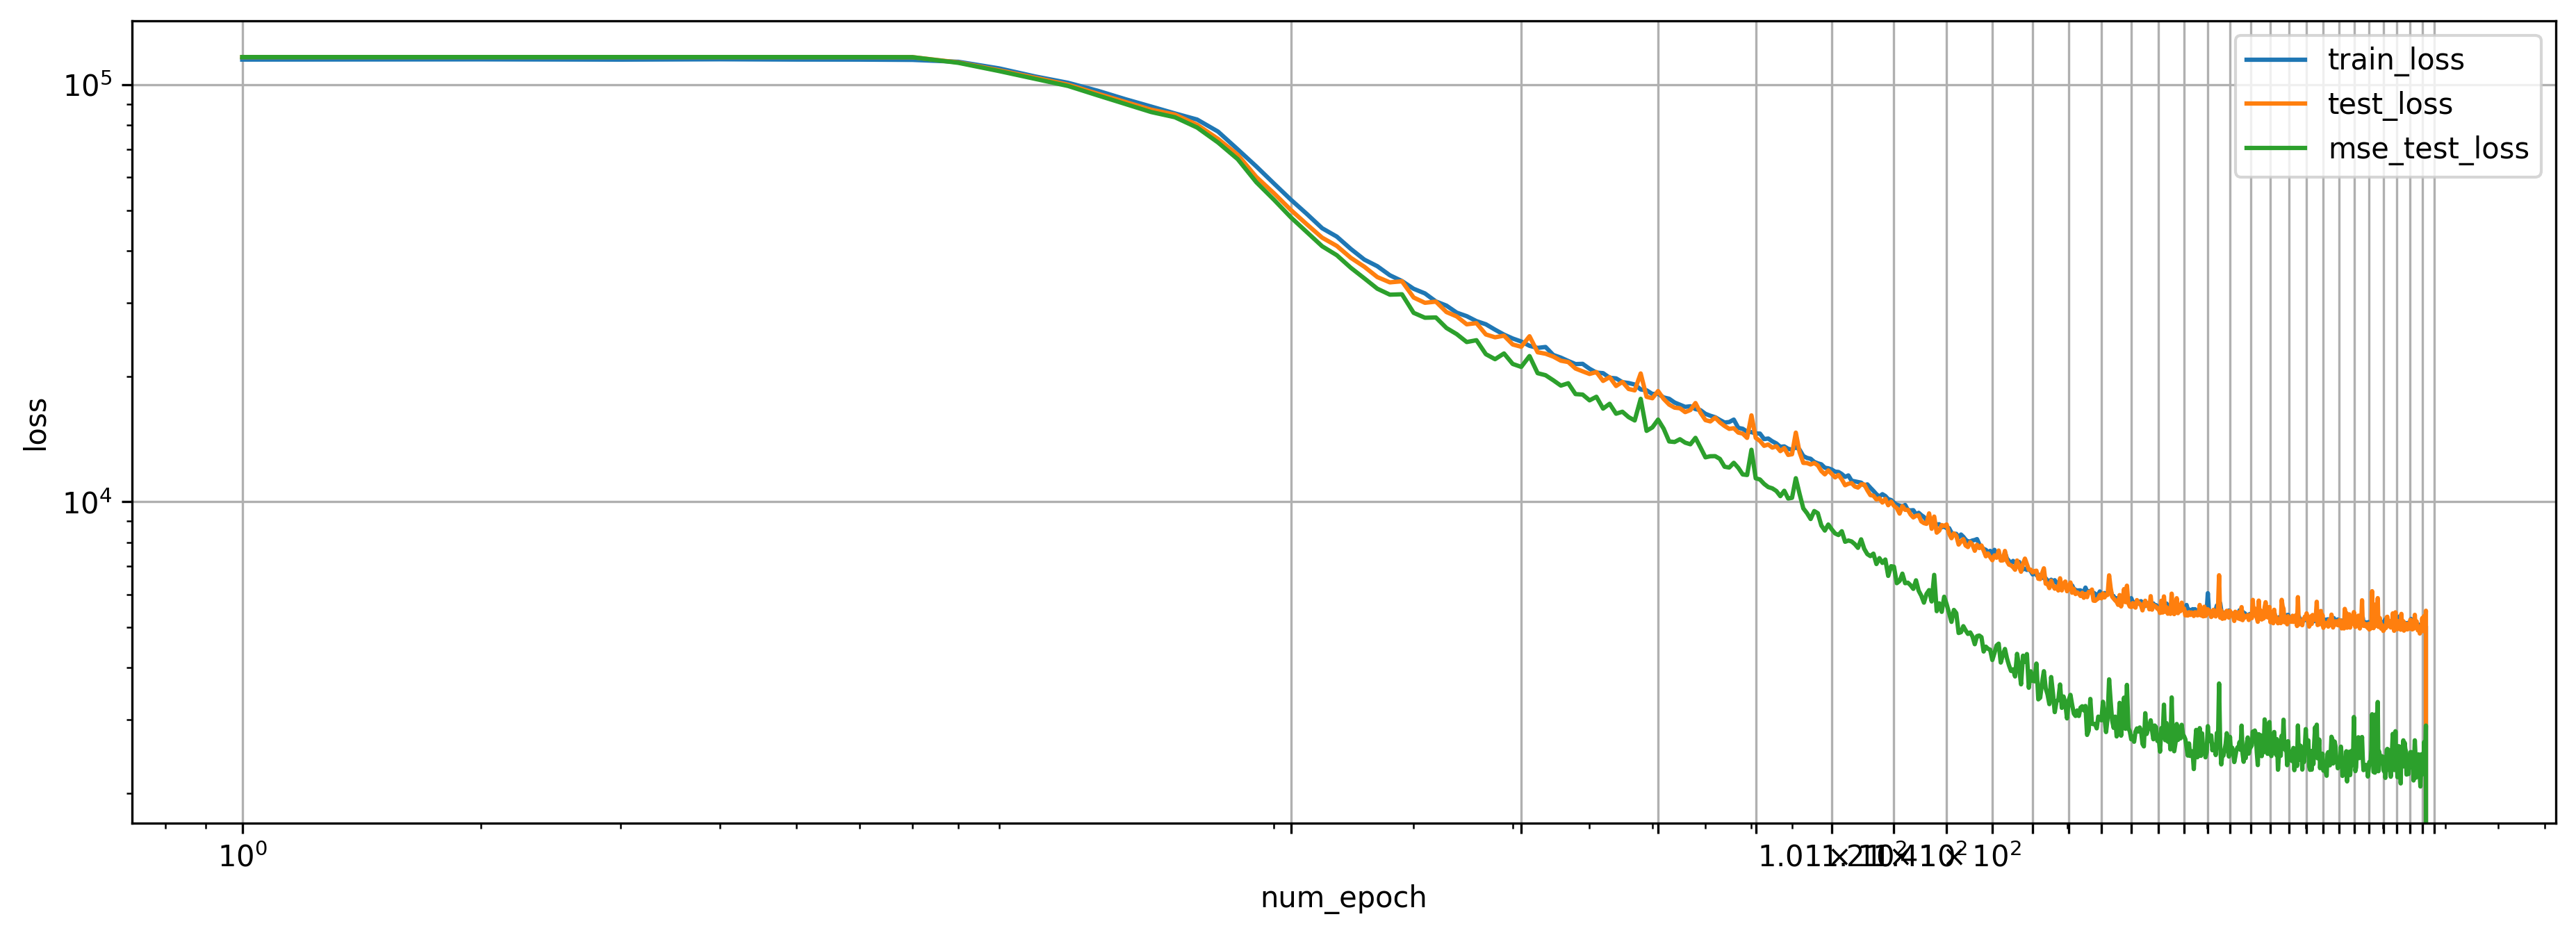

In [41]:
plt.figure(figsize=(15, 5), dpi=300)
plt.loglog(np.arange(1, tl.shape[0] + 1), tl, label='train_loss')
plt.loglog(np.arange(1, vl.shape[0] + 1), vl, label='test_loss')
plt.loglog(np.arange(1, ml.shape[0] + 1), ml, label='mse_test_loss')
#plt.loglog(np.arange(1, kl.shape[0] + 1), kl, label='kl_test_loss')
# plt.loglog(np.arange(1, train_losses.shape[0] + 1), kl_train_losses, label='kl_train_loss')
# plt.loglog(np.arange(1, val_losses.shape[0] + 1), kl_val_losses, label='kl_test_loss')
plt.xticks(np.arange(1, tl.shape[0] + 1, 20))
plt.xlabel('num_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

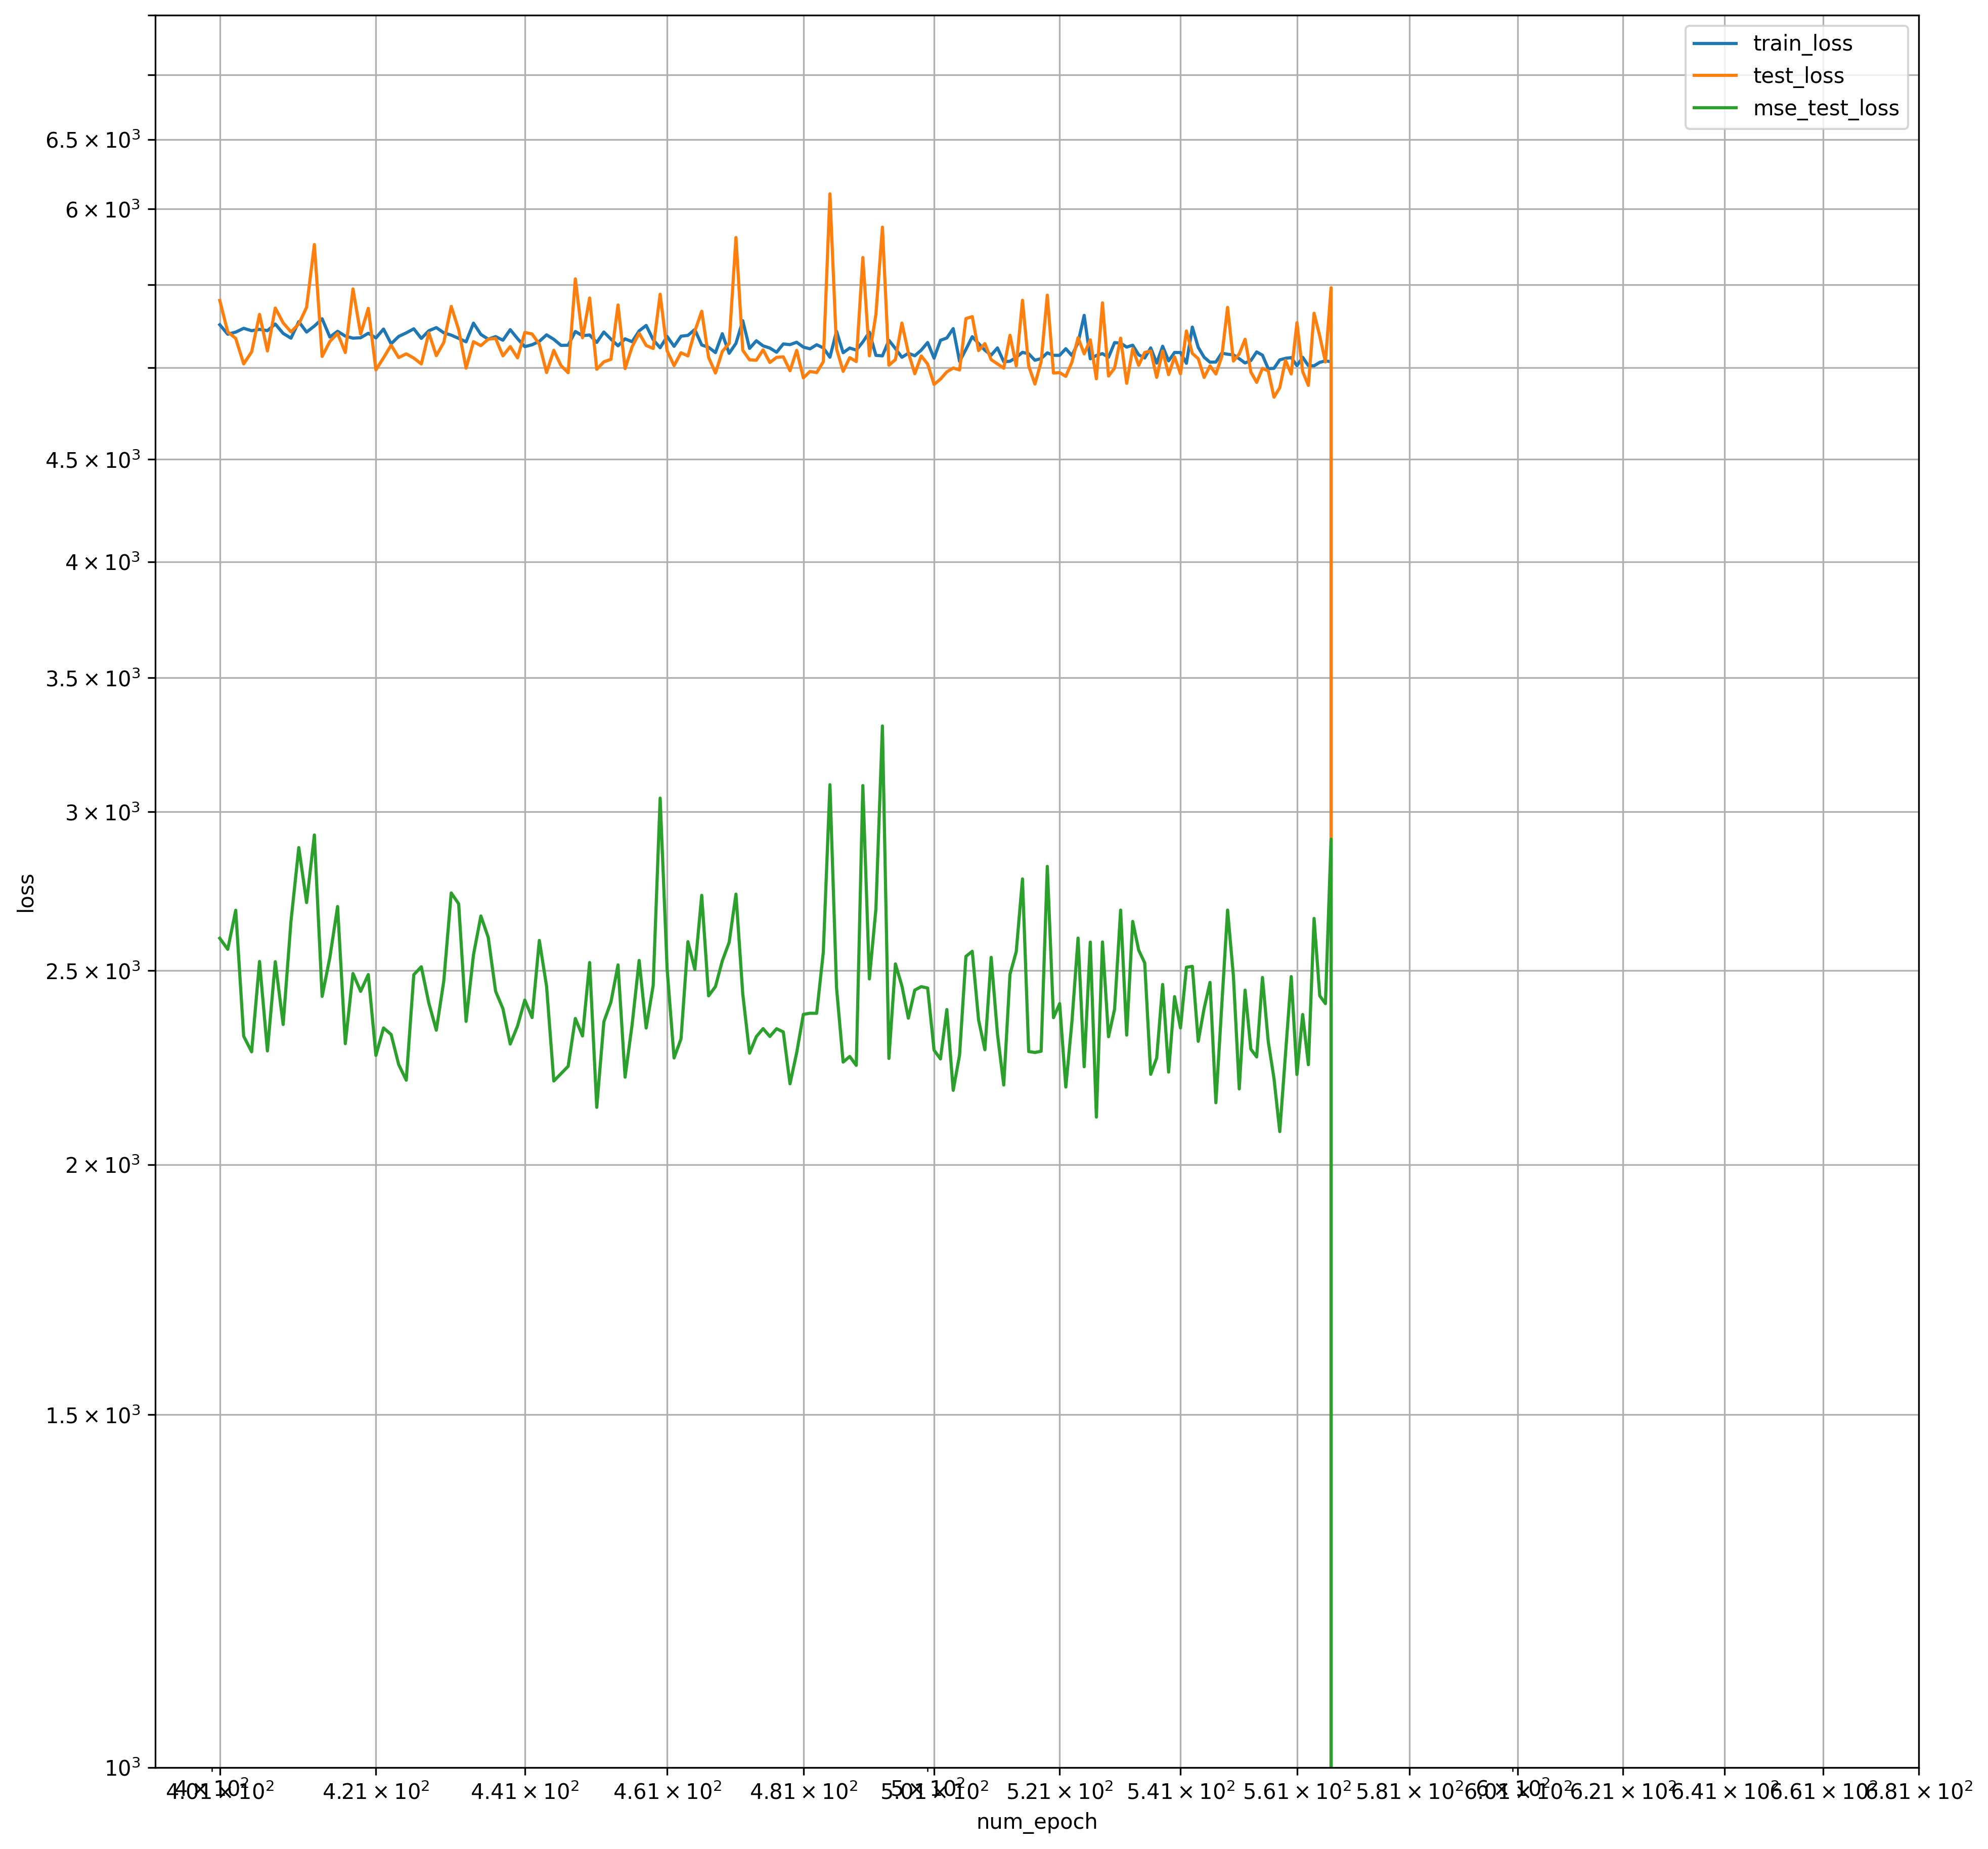

In [43]:
plt.figure(figsize=(15, 15), dpi=300)
plt.loglog(np.arange(401, tl.shape[0] + 1), tl[400:], label='train_loss')
plt.loglog(np.arange(401, vl.shape[0] + 1), vl[400:], label='test_loss')
plt.loglog(np.arange(401, ml.shape[0] + 1), ml[400:], label='mse_test_loss')
plt.xticks(np.arange(401, 700, 20))
plt.yticks(np.arange(1* 10**3, 8 * 10**3, 500))
plt.xlabel('num_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

# Audio Reconstruction

In [39]:
save_dir = 'best_checkpoint.pth'
checkpoint = torch.load(save_dir)
autoencoder.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['epoch'], checkpoint['loss'], checkpoint['mse_loss'], checkpoint['kl_loss'])

19 116490.6630859375 116490.6630859375 0.0


In [53]:
from random import randint
test = [randint(0, data.shape[0]) for _ in range(5)]
test

[1809, 3283, 1870, 2146, 1138]

In [54]:
def predict_sample(input_data):
    with torch.no_grad():
        model_input = torch.tensor(input_data).type(torch.FloatTensor).unsqueeze(0).to(device)
        pred = autoencoder(model_input).squeeze().cpu().numpy()
        print(pred.shape)
    audio = reconstruct_signal(spec=pred, hop_size=HOP_SIZE, frame_size=FRAME_SIZE, sig=SIGMA)
    return audio

In [55]:
import IPython.display as ipd
import soundfile as sf

In [56]:
reconstructed_audio = []
original_audio = []
i = 1
for num in test:
    r_audio = predict_sample(data[num])
    o_audio = reconstruct_signal(spec=data[num], hop_size=HOP_SIZE, frame_size = FRAME_SIZE, sig=SIGMA)
    reconstructed_audio.append(r_audio)
    original_audio.append(o_audio)
    sf.write(f'./test_dir/original_file{i}.wav', o_audio, samplerate=SAMPLE_RATE)
    sf.write(f'./test_dir/reconstructed_file{i}.wav', r_audio, samplerate=SAMPLE_RATE)
    i += 1


(2, 513, 216)
(2, 513, 216)
(2, 513, 216)
(2, 513, 216)
(2, 513, 216)


In [57]:
ipd.Audio(original_audio[2], rate=SAMPLE_RATE)

In [58]:
ipd.Audio(reconstructed_audio[2], rate=SAMPLE_RATE)

In [ ]:
type(original_audio)